# SpeedySpeech: Efficient Neural Speech Synthesis
Claudio Pastorini - 1792086

[pastorini.1792086@studenti.uniroma1.it](mailto:pastorini.1792086@studenti.uniroma1.it)

# Introduction

In [68]:
# Installs needed packages
!pip install g2p_en barbar pytorch_ssim pytorch-ignite pandas matplotlib librosa tensorboard fastdtw tabulate

You should consider upgrading via the '/home/claudio/Projects/University/NeuralNetwork/speedyspeechpytorch/.direnv/python-3.9.6/bin/python -m pip install --upgrade pip' command.


In [69]:
import os
import time
import re
import random

import torch

import numpy as np

# Avoids to have problem with warning message
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd

import librosa.display
from g2p_en import G2p
from torch.utils.tensorboard import SummaryWriter
from barbar import Bar
from IPython.display import Markdown, display

# Use matplotlib with inline backend (no interaction)
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

print(torch.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
1.9.0+cu102


In [70]:
# Uncomment if working on Colab
# from google.colab import drive

# Mounts Google Drive
# drive.mount("/content/gdrive")

# Defines your current path for storing the checkpoints and other stuffs
# root_path = '/content/gdrive/MyDrive/Corsi/_Correnti/Neural Networks/SpeedySpeech/'

In [71]:
# Uncomment if working locally
root_path = '/home/claudio/Projects/University/NeuralNetwork/speedyspeechpytorch/'

In [72]:
# Uncomment if working on paperspace
# root_path = '/notebooks/'

In [73]:
# Defines the dataset path
dataset_path = f'{root_path}dataset/LJSpeech-1.1/'

In [74]:
# Uncomment if needed and working on Colab (pay attention to the destination folder, no python code involved so use absolute path here)

# Downloads LJSpeech dataset
# print("Downloading LJSpeech dataset...")
# !wget -O "/content/gdrive/MyDrive/Corsi/_Correnti/Neural Networks/SpeedySpeech/dataset/LJSpeech-1.1.tar.bz2"  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

In [75]:
# Uncomment if needed and working locally (pay attention to the destination folder, no python code involved so use absolute path here)

# Downloads LJSpeech dataset
# print("Downloading LJSpeech dataset...")
# !wget -O "/home/claudio/Projects/University/NeuralNetwork/speedyspeechpytorch/dataset/LJSpeech-1.1.tar.bz2"  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

In [76]:
# Uncomment if needed and working on paperspace (pay attention to the destination folder, no python code involved so use absolute path here)

# Downloads LJSpeech dataset
# print("Downloading LJSpeech dataset...")
# !wget -O "/notebooks/dataset/LJSpeech-1.1.tar.bz2"  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

In [77]:
# Uncomment if needed and working on Colab (pay attention to the destination folder, no python code involved so use absolute path here)

# Extracts the dataset
# print("Extracting LJSpeech dataset...")
#!tar xjf "/content/gdrive/MyDrive/Corsi/_Correnti/Neural Networks/SpeedySpeech/dataset/LJSpeech-1.1.tar.bz2" -C "/content/gdrive/MyDrive/Corsi/_Correnti/Neural Networks/SpeedySpeech/dataset/"

In [78]:
# Uncomment if needed and working on Colab (pay attention to the destination folder, no python code involved so use absolute path here)

# Extracts the dataset
# print("Extracting LJSpeech dataset...")
# !tar xjf "/home/claudio/Projects/University/NeuralNetwork/speedyspeechpytorch/dataset/LJSpeech-1.1.tar.bz2" -C "/home/claudio/Projects/University/NeuralNetwork/speedyspeechpytorch/dataset/"

In [79]:
# Uncomment if needed and working on paperspace (pay attention to the destination folder, no python code involved so use absolute path here)

# Extracts the dataset
# print("Extracting LJSpeech dataset...")
# !tar xjf "/notebooks/dataset/LJSpeech-1.1.tar.bz2" -C "/notebooks/dataset/"

In [80]:
# Uncomment if needed and working on Colab (pay attention to the destination folder, no python code involved so use absolute path here)

# print("Downloading MelGAN model...")
# !wget -O "/content/gdrive/MyDrive/Corsi/_Correnti/Neural Networks/SpeedySpeech/model/Melgan/melgan.pth" https://github.com/seungwonpark/melgan/releases/download/v0.1-alpha/nvidia_tacotron2_LJ11_epoch3200.pt

In [81]:
# Uncomment if needed and working locally (pay attention to the destination folder, no python code involved so use absolute path here)

# print("Downloading MelGAN model...")
# !wget -O "/home/claudio/Projects/University/NeuralNetwork/speedyspeechpytorch/model/Melgan/melgan.pth" https://github.com/seungwonpark/melgan/releases/download/v0.1-alpha/nvidia_tacotron2_LJ11_epoch3200.pt

In this work we are going to reimplement the [SpeedySpeech: Efficient Neural Speech Synthesis](https://arxiv.org/pdf/2008.03802.pdf) paper by Jan Vainer and Ondřej Dušek from Charles University, Faculty of Mathematics and Physics, Prague, Czechia.  

In this paper the authors proposed a **student-teacher network** capable of **high-quality faster-than-real-time spectrogram synthesis**, with **low requirements on computational resources** and **fast training time**.  
The results obtained seems to be surprising compared to the state-of-art solutions.

## Introduction
We reimplement the [SpeedySpeech: Efficient Neural Speech Synthesis](https://arxiv.org/pdf/2008.03802.pdf) paper by Jan Vainer and Ondřej Dušek from Charles University, Faculty of Mathematics and Physics, Prague, Czechia.  

A **student-teacher network** capable of **high-quality faster-than-real-time spectrogram synthesis**, with **low requirements on computational resources** and **fast training time**.

In [82]:
short_sample_audio_path = f'{root_path}audios/short.wav'
ipd.Audio(short_sample_audio_path)

In [83]:
longer_sample_audio_path = f'{root_path}audios/long.wav'
ipd.Audio(longer_sample_audio_path)

In [84]:
punctuation_sample_audio_path = f'{root_path}audios/punctuation.wav'
ipd.Audio(punctuation_sample_audio_path)

# Text-To-Speech
First of all we have to understand what is a **Text-To-Speech (TTS)** system.

From the Wikipedia page about [Speech synthesis](https://en.wikipedia.org/wiki/Speech_synthesis):


> Speech synthesis is the artificial production of human speech. A computer system used for this purpose is called a speech computer or speech synthesizer, and can be implemented in software or hardware products. A text-to-speech (TTS) system converts normal language text into speech; other systems render symbolic linguistic representations like phonetic transcriptions into speech.

A text-to-speech system is composed of two parts: 

* a **front-end** executes the *text normalization* converting raw text (like numbers and abbreviations) into the equivalent of written-out words and assign phonetic transcriptions to words with the *text-to-phoneme* process
* a **back-end** executes the audio *synthesis* converting the symbolic linguistic representation into sound

<br>
<center><img src="images/text_to_speech_diagram.png"></center>

A text-to-speech system is composed of two parts: a front-end and a back-end. 

![Text to speech diagram](images/text_to_speech_diagram.png)

The front-end has two major tasks: 

* First, it converts raw text containing *symbols like numbers and abbreviations into the equivalent of written-out words*. This process is often called **text normalization**, pre-processing, or tokenization.

* Then, it assigns *phonetic transcriptions to each word*, and *divides and marks the text into prosodic units*, like phrases, clauses, and sentences. The process of assigning phonetic transcriptions to words is called **text-to-phoneme** or grapheme-to-phoneme conversion. 

Phonetic transcriptions and prosody information together make up the symbolic linguistic representation that is output by the front-end.  

The back-end — often referred to as the **synthesizer** — then *converts the symbolic linguistic representation into sound*. In certain systems, this part includes the computation of the target prosody (pitch contour, phoneme durations), which is then imposed on the output speech. 

## A brief of history

### The Voder

In the 1930s Bell Labs developed the vocoder, which automatically analyzed speech into its fundamental tones and resonances. From his work on the vocoder, Homer Dudley developed a keyboard-operated voice-synthesizer called **The Voder** (Voice Demonstrator), which he exhibited at the 1939 New York World's Fair. 

The Bell Telephone Laboratory's Voder (Voice Operating Demonstrator) was the *first attempt to synthesise human speech by breaking it down into its component sounds and then reproducing the sound patterns electronically to create speech*.  

![Voder](images/voder.png)

### The Voder

<img src="images/voder.png" width="500">

### Daisy bell

It is the earliest song sung using computer speech synthesis by the IBM 704 in 1961, a feat which was referenced in the film *2001: A Space Odyssey (1968)*. 


In [85]:
short_sample_audio_path = f'{root_path}audios/daisy_bell.mp3'
ipd.Audio(short_sample_audio_path)

### Daisy bell
In 1961, physicist John Larry Kelly, Jr. and his colleague Louis Gerstman used an IBM 704 computer to synthesize speech, an event among the most prominent in the history of Bell Labs. Kelly's *voice recorder synthesizer (vocoder) recreated the song "Daisy Bell"*, with musical accompaniment from Max Mathews.

### Deep learning-based synthesis

In September 2016, DeepMind proposed **WaveNet**, a *deep generative model of raw audio waveforms*. This showed the community that deep learning-based models have the capability to model raw waveforms and perform well on generating speech from acoustic features like spectrograms or spectrograms in mel scale, or even from some preprocessed linguistic features. 

In early 2017, Mila (research institute) proposed **char2wav**, a *model to produce raw waveform in an end-to-end method*. Also, Google and Facebook proposed **Tacotron** and **VoiceLoop** respectively, to *generate acoustic features directly from the input text*. Later in the same year, Google proposed Tacotron2 which combined the WaveNet vocoder with the revised Tacotron architecture to perform end-to-end speech synthesis. Tacotron2 can generate high-quality speech approaching the human voice. 

Since then, end-to-end methods became the hottest research topic because many researchers around the world started to notice the power of the end-to-end speech synthesizer. 

### Deep learning-based synthesis

In September 2016, DeepMind proposed **WaveNet**, a *deep generative model of raw audio waveforms*. 

In early 2017, Mila (research institute) proposed **char2wav**, a *model to produce raw waveform in an end-to-end method*.

Google proposed **Tacotron** and then **Tacotron2**, Facebook instead proposed **VoiceLoop**.

Since then, end-to-end methods became the hottest research topic because many researchers around the world start to notice the power of the end-to-end speech synthesizer. 

## Challenges

* Text normalization
* Text-to-phoneme
* Evaluation
* Prosodics and emotional content

## Challenges

Different challenges were met by the researchers during the years. **Text normalization** is a known problem also in other fields such as Information Retrieval and several techniques were developed in order to address it.

Another problem is **text-to-phoneme**: there is a simple map between grapheme to phoneme but it is different for each language and there are different.

Another problem that raised with time is the problem related to the **evaluation** of the results generated by the synthetizer. With time the researcheds come to the conclusion that each work should be evaluated by a pool of users considering the audio generated by the synthetizer and other synthetizer with the same phrases.

A really big problem not yet issued is the one related to the **prosodics and emotional content**. The audio generated is always flat and without emotion. Using GAN seems to solve the problem addressing the prosodics, instead for the emotional content different models should be used trained on dataset with audios and emotion.

# Dataset

The dataset that will be used is the [LJ-Speech-Dataset](https://keithito.com/LJ-Speech-Dataset/), a public domain speech dataset consisting of **13.100 short audio clips** of a single speaker reading passages from 7 non-fiction books. 

A transcription is provided for each clip, whose length varies from 1 to 10 seconds, adding up to approximately 24 hours. 

Metadata is provided in `transcripts.csv` file and it consists of one record per line, delimited by the pipe character (`0x7c`).

The fields are:

* **ID**: this is the name of the corresponding `.wav` file
* **Transcription**: words spoken by the reader (`UTF-8`)
* **Normalized Transcription**: transcription with numbers, ordinals, and monetary units expanded into full words (`UTF-8`).

Each audio file is a single-channel *16-bit PCM WAV* with a sample rate of *22.050 Hz*. 

In [86]:
# code/datasets/AudioDataset.py

from librosa.core import load

def load_alignments(file):
    with open(file) as f:
        alignments = [[int(x) for x in l.split(',')] for l in f.readlines()]

    return alignments

class AudioDataset(torch.utils.data.Dataset):
    """
    Expects the following structure
    root|- wavs
        |- metadata.csv
        |- durations.txt
    text.csv contains 3 columns - filename|text|tokenized-text (numbers to words etc.)
        The names must be alphabetically ordered
        The filename does not contain file type
        Columns are separated by pipe character
    wavs is a folder with audio files. Names correspond to `filename` field in text.csv
    durations.csv contain comma-separated integers, one row of integers per one row
        If use_phonemes is true, durations are expected to correspond to phonemes
        Else alignmnets are expected to correspond to text
    """

    def __init__(self, root, start_idx=0, end_idx=None, durations=False):
        super(AudioDataset, self).__init__()

        self.root = root
        self.start_idx, self.end_idx = start_idx, end_idx

        self.wavs = os.path.join(self.root, 'wavs')
        self.text = os.path.join(self.root, 'metadata.csv')
        self.durations = False if not durations else os.path.join(self.root, durations)
        self.wav_idx = sorted(os.listdir(self.wavs))[start_idx:end_idx]
        
        with open(self.text, encoding="utf-8") as txt:
            self.text_idx = [l.strip().split("|")[2].strip() for l in txt.readlines()][start_idx:end_idx]

        if self.durations:
            self.align_idx = load_alignments(self.durations)[start_idx:end_idx]

    def __getitem__(self, idx):
        wav = load(os.path.join(self.wavs, self.wav_idx[idx]))[0]
        text = self.text_idx[idx]
        alignment = self.align_idx[idx] if self.durations else None
        
        return text, wav, alignment

    def __len__(self):
        return len(self.wav_idx)

  A brief example of the `transcript.csv`:

In [87]:
dataset_metadata = pd.read_csv(f'{dataset_path}metadata.csv', sep='|', names=['ID', 'Transcription', 'Normalized Transcription'], index_col=0)
dataset_metadata.head()
#Markdown(dataset_metadata.head().to_markdown())

,Transcription,Normalized Transcription
ID,,
LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
LJ001-0002,in being comparatively modern.,in being comparatively modern.
LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


## Graphemes vs phonemes
As for the speech synthesis, we are interested in the **phonemes** (*unit of sound*) and not **graphemes** (the *transcription of the phoneme*). So we need to transform all the graphemes, representing the transcription, into phonemes. 

For this purpose, we will use the [g2p](https://github.com/Kyubyong/g2p) library that can convert English graphemes to phonemes.

Using the library we are able to perform the transformation over all our samples and we obtain something like this:

In [88]:
g2p = G2p()

dataset_metadata_phonemized = dataset_metadata.copy()

dataset_metadata_phonemized['Phonemes'] = dataset_metadata_phonemized.apply(lambda row : "".join(g2p(row['Normalized Transcription'])), axis = 1)
dataset_metadata_phonemized.head()
# display(Markdown(dataset_metadata_phonemized.head().to_markdown()))

,Transcription,Normalized Transcription,Phonemes
ID,,,
LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ...","PRIH1NTIH0NG , IH0N DHAH0 OW1NLIY0 SEH1NS WIH1..."
LJ001-0002,in being comparatively modern.,in being comparatively modern.,IH0N BIY1IH0NG KAH0MPEH1RAH0TIH0VLIY0 MAA1DER0N .
LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...,FAO1R AO2LDHOW1 DHAH0 CHAY0NIY1Z TUH1K IH0MPRE...
LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed...","PRAH0DUW1ST DHAH0 BLAA1K BUH1KS , WIH1CH WER0 ..."
LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...,DHAH0 IH0NVEH1NSHAH0N AH1V MUW1VAH0BAH0L MEH1T...


Now let's listen to a random sample inside the dataset:

In [89]:
# Picks one audio randomly
from os import listdir
from os.path import isfile, join
import random

wavs_path = f'{dataset_path}wavs/'

# Retrieves all the filenames inside the dataset path
file_names = [f for f in listdir(wavs_path) if isfile(join(wavs_path, f))]

# Takes a random file 
sample_audio_file_name = random.choice(file_names)

print(f'Pick sample: {sample_audio_file_name}')

Pick sample: LJ050-0227.wav


In [90]:
# Generates the path of the sample audio
sample_audio_path = f'{dataset_path}wavs/{sample_audio_file_name}'

# Plays the sample audio
ipd.Audio(sample_audio_path)

And the metadata for this particular sample is:

In [91]:
sample_data = dataset_metadata_phonemized.loc[sample_audio_file_name[:-4]]
sample_data
# display(Markdown(sample_data.to_markdown()))

Transcription               in case of unexpected need; and 25 additional ...
Normalized Transcription    in case of unexpected need; and twenty-five ad...
Phonemes                    IH0N KEY1S AH1V AH2NIH0KSPEH1KTIH0D NIY1D AH0N...
Name: LJ050-0227, dtype: object

## Audio signal representation

Before moving onto the network, it is important to understand all the different ways through which an audio signal can be represented.

One possible way is to simply represent the *variation of the amplitude along the time*.

So, considering the previous sample, we have the following representation:

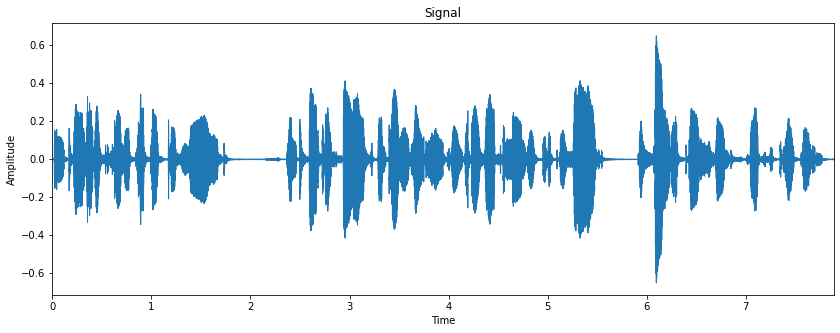

In [92]:
x, sr = librosa.load(sample_audio_path, sr=22050)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.title("Signal")
plt.ylabel('Amplitude');

However, as each audio signal is composed by multiple frequencies, we can also represent it as a **spectrum**, so to show the *variation of the amplitude along the frequency* instead of time, thanks to the *Short-Time Fourier Transform algorithm*:

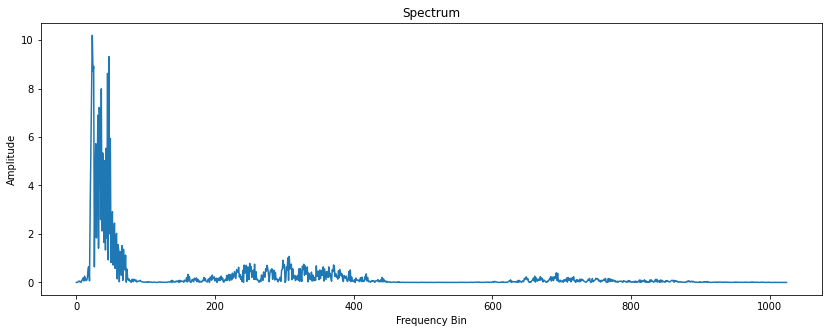

In [93]:
plt.figure(figsize=(14, 5))
ft = np.abs(librosa.stft(x[:2048], hop_length=2048 + 1))
plt.plot(ft);
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

In this way we have lost the information about the time.

Generally, audio signals -such as music or voice- are not periodic; therefore, we lose an important piece of information by removing it from the graph.

A solution to this is to compute different *SFTs on overlapping windowed segments of the signal*, producing the so-called **spectrogram**.


<img src="images/STFT.png" width="500">

![STFT](images/STFT.png)

With this representation we can see the *variations of frequency and amplitude during time* in our signal. Amplitude is expressed in dB with different colours.

The **spectogram** of our sample signal is:

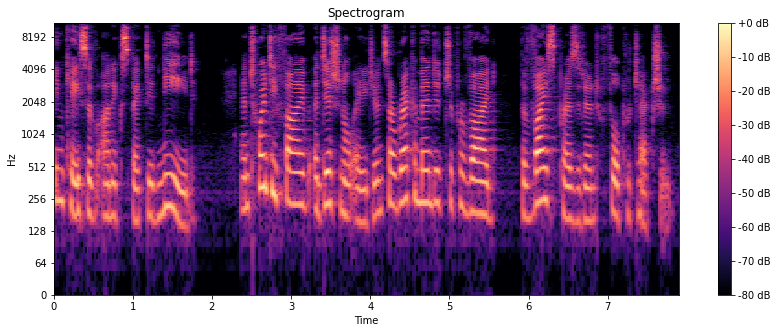

In [94]:
plt.figure(figsize=(14, 5))
spec = np.abs(librosa.stft(x, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

In this paper, as in others dealing with signals representing voices, the spectrogram used is not a normal spectogram but it the so-called **Mel spectogram**.

A Mel spectogram is a *spectogram that uses a different scale (the Mel scale) for the frequencies*. 

The Mel scale was created by Stevens, Volkmann, and Newmann in the 1937 as a scale that *puts stress to the fact that humans are not able to identify well differences in higher frequencies*. 

For example, we can easily tell the difference between 500 and 1000 Hz, but we will hardly be able to tell a difference between 10.000 and 10.500 Hz, even though the distance between the two pairs are the same!

<img src="images/mel_scale.png" width="500">

So we need to remap the frequency scale to the Mel scale and we obtain the **Mel spectogram**:

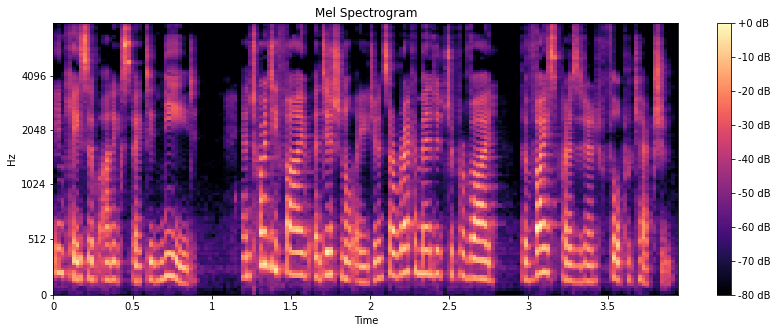

In [95]:
plt.figure(figsize=(14, 5))
mel_spect = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB');

# The network

## The Teacher-Student network

This type of network was introduced to solve the problem of the overwhelming size of Deep Neural Networks.
In fact, **it tries to transfer knowledge from a complex teacher network to a simple student network.**

## The Teacher-Student network

This type of network was introduced to solve the problem of the overwhelming size of Deep Neural Networks (DNN). **Teacher-Student tries to transfer knowledge from a complex teacher network to a simple student network.**

The hypothesis is that the student will be able to learn the underlying concepts and knowledge learned by the teacher that the student otherwise wouldn’t be able to learn because of its simpler architecture and fewer number of parameters. This knowledge transfer is achieved by minimizing the loss between the soft labels produced by the teacher and the student.

If the student network is guided to replicate the behavior of the teacher network (which has already searched through a bigger solution space), it is expected to have its convergence space overlapping with the original teacher network convergence space.

<center><img src="images/teacher_student_solution_space.png" width=700></center>

![Teacher and student solution spaces](images/teacher_student_solution_space.png)

In [96]:
# code/functional.py

import torch
import numpy as np
import matplotlib.pyplot as plt


def scaled_dot_attention(q, k, v, mask=None, noise=0, dropout=lambda x: x):
    """
    :param q: queries, (batch, time1, channels1)
    :param k: keys, (batch, time2, channels1)
    :param v: values, (batch, time2, channels2)
    :param mask: boolean mask, (batch, time1, time2)
    :param dropout: a dropout function - this allows keeping dropout as a module -> better control when training/eval
    :return: (batch, time1, channels2), (batch, time1, time2)
    """

    # (batch, time1, time2)
    weights = torch.matmul(q, k.transpose(2, 1))
    if mask is not None:
        weights = weights.masked_fill(~mask, float('-inf'))

    if noise:
        weights += noise * torch.randn(weights.shape).to(weights.device)

    weights = torch.softmax(weights, dim=-1)
    weights = dropout(weights)

    result = torch.matmul(weights, v)  # (batch, time1, channels2)
    return result, weights


def positional_encoding(channels, length, w=1):
    """The positional encoding from `Attention is all you need` paper

    :param channels: How many channels to use
    :param length: 
    :param w: Scaling factor
    :return:
    """
    enc = torch.FloatTensor(length, channels)
    rows = torch.arange(length, out=torch.FloatTensor())[:, None]
    cols = 2 * torch.arange(channels//2, out=torch.FloatTensor())

    enc[:, 0::2] = torch.sin(w * rows / (10.0**4 ** (cols / channels)))
    enc[:, 1::2] = torch.cos(w * rows / (10.0**4 ** (cols / channels)))
    return enc


def median(distribution, keepdim=True):
    cum_dist = torch.cumsum(distribution, dim=-1)
    return torch.sum(cum_dist < 0.5, -1, keepdim=keepdim).float()


def median_mask(distribution, window=(5,5)):
    """Expects distribution of shape (batch, time, channels)"""
    med = median(distribution)
    m = torch.ones(distribution.shape).float() * torch.arange(distribution.shape[-1]).float()
    m = m.to(distribution.device)
    mask = (med - window[0] <= m) * (m <= med + window[1])
    return mask


def idx_mask(shape, idx, size):
    """

    :param distribution: (batch, time, channels)
    :param idx: (batch, len_spectrograms, 1) eg torch.argmax(weights).unsqueeze(-1)
    :param size:
    :return:
    """
    m = torch.ones(shape).float() * torch.arange(shape[-1]).float()
    m = m.to(idx.device)
    mask = (idx <= m) * (m <= idx + size)
    return mask


def mask(shape, lengths, dim=-1):

    assert dim != 0, 'Masking not available for batch dimension'
    assert len(lengths) == shape[0], 'Lengths must contain as many elements as there are items in the batch'

    lengths = torch.as_tensor(lengths)

    to_expand = [1] * (len(shape)-1)+[-1]
    mask = torch.arange(shape[dim]).expand(to_expand).transpose(dim, -1).expand(shape).to(lengths.device)
    mask = mask < lengths.expand(to_expand).transpose(0, -1)
    return mask


def get_phoneme_durations(alignment):
    """Alignment must be a batch

    :return counts: [(idx, count), ...]
    """

    alignment = torch.as_tensor(alignment)
    maxx = torch.max(alignment, dim=-1)[1]
    counts = [torch.unique(m, return_counts=True) for m in maxx]

    return counts


def display_spectr_alignment(spec_supervised, align_supervised, spec_generated, align_generated, text):
    """

    :param spectrogram_supervised: (time, channels), expected on gpu, no grad attached
    :param alignment: (time, phonemes)
    :return: figure
    """
    s1 = spec_generated.detach().cpu().numpy().T
    a1 = align_generated.detach().cpu().numpy().T
    m1 = np.argmax(a1, axis=0) + s1.shape[0]
    sa1 = np.concatenate((s1, a1), axis=0)

    s2 = spec_supervised.detach().cpu().numpy().T
    a2 = align_supervised.detach().cpu().numpy().T
    m2 = np.argmax(a2, axis=0) + s2.shape[0]
    sa2 = np.concatenate((s2, a2), axis=0)

    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.suptitle(text)
    ax[0].imshow(sa1, interpolation='none')
    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].plot(m1, color='red', linestyle='--', alpha=0.7)

    ax[1].imshow(sa2, interpolation='none')
    ax[1].xaxis.set_ticks_position('bottom')
    ax[1].plot(m2, color='red', linestyle='--', alpha=0.7)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig


def pad_batch(items, pad_value=0):
    """Pad tensors in list to equal length (in the first dim)

    :param items:
    :param pad_value:
    :return: padded_items, orig_lens
    """
    max_len = len(max(items, key=lambda x: len(x)))
    zeros = (2*torch.as_tensor(items[0]).ndim -1) * [pad_value]
    padded_items = torch.stack([torch.nn.functional.pad(torch.as_tensor(x), pad= zeros + [max_len - len(x)], value=pad_value)
                          for x in items])
    orig_lens = [len(xx) for xx in items]
    return padded_items, orig_lens


In [97]:
# code/utils/masked.py
# Makes the mask function a MaskedBatchNorm1d's method in order to avoid problems with functional.mask function

import torch


class MaskedBatchNorm1d(torch.nn.BatchNorm1d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super(MaskedBatchNorm1d, self).__init__(num_features, eps=eps, momentum=momentum,
                                                affine=affine, track_running_stats=track_running_stats)

    def mask(self, x, lengths, dim=-1):

        assert dim != 0, 'Masking not available for batch dimension'
        assert len(lengths) == x.shape[0], 'Lengths must contain as many elements as there are items in the batch'

        lengths = torch.as_tensor(lengths)

        to_expand = [1] * (x.ndim-1)+[-1]
        mask = torch.arange(x.shape[dim]).expand(to_expand).transpose(dim, -1).expand(x.shape).to(lengths.device)
        mask = mask < lengths.expand(to_expand).transpose(0, -1)
        return mask.to(x.device)

    def forward(self, input, lens):
        """

        :param input: (batch, channels, time)
        :param lens:
        :return:
        """
        self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        m = mask(input, lens, dim=-1)

        # calculate running estimates
        if self.track_running_stats:
            if self.training:
                mean = masked_mean(input, m, dim=[0, 2], keepdim=False)
                # use biased var in train
                var = masked_var(input, m, dim=[0, 2], unbiased=False, keepdim=False)
                n = input.numel() / input.size(1)  # number of averaged items
                with torch.no_grad():
                    self.running_mean = exponential_average_factor * mean \
                                        + (1 - exponential_average_factor) * self.running_mean
                    # update running_var with unbiased var
                    self.running_var = exponential_average_factor * var * n / (n - 1) \
                                       + (1 - exponential_average_factor) * self.running_var
            else:
                mean = self.running_mean
                var = self.running_var
        else:
            mean = masked_mean(input, m, dim=[0, 2], keepdim=False)
            # use biased var in train
            var = masked_var(input, m, dim=[0, 2], unbiased=True, keepdim=False)

        input = (input - mean[None, :, None]) / (torch.sqrt(var[None, :, None] + self.eps))
        if self.affine:
            input = input * self.weight[None, :, None] + self.bias[None, :, None]

        return input


def masked_max(x, mask, dim=None, keepdim=False):
    if dim is None:
        return torch.max(x.masked_fill(~mask, float('-inf')))
    return torch.max(x.masked_fill(~mask, float('-inf')), dim=dim, keepdim=keepdim)


def masked_min(x, mask, dim=None, keepdim=False):
    if dim is None:
        return torch.min(x.masked_fill(~mask, float('inf')))
    return torch.min(x.masked_fill(~mask, float('inf')), dim=dim, keepdim=keepdim)


def masked_sum(x, mask, dim=None, keepdim=False):
    if dim is None:
        dim = tuple([i for i in range(x.ndim)])
    return torch.sum(x.masked_fill(~mask, 0.0), dim=dim, keepdim=keepdim)


def masked_mean(x, mask, dim=None, keepdim=False):
    if dim is None:
        dim = tuple([i for i in range(x.ndim)])
    s = masked_sum(x, mask, dim, keepdim)
    return s / mask.sum(dim=dim, keepdim=keepdim).float()


def masked_var(x, mask, dim=None, keepdim=False, unbiased=True):
    if dim is None:
        dim = tuple([i for i in range(x.ndim)])

    m = masked_mean(x, mask, dim, keepdim=True)
    m = masked_sum(torch.pow(x - m, 2.0), mask, dim, keepdim)
    if unbiased:
        return m / (mask.sum(dim=dim, keepdim=keepdim) - 1).float()

    return m / (mask.sum(dim=dim, keepdim=keepdim)).float()


def masked_std(x, mask, dim=None, keepdim=False, unbiased=True):
    return torch.sqrt(masked_var(x, mask, dim, keepdim, unbiased))


In [98]:
# code/layers.py

import torch.nn as nn
import torch
from torch import tanh, sigmoid

# No need to import: from functional import scaled_dot_attention
from torch.nn import LayerNorm
# No need to import: from utils.masked import MaskedBatchNorm1d


class Conv1d(nn.Conv1d):
    """A wrapper around nn.Conv1d, that works on (batch, time, channels)"""

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, dilation=1, groups=1, bias=True, padding=0):
        super(Conv1d, self).__init__(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=kernel_size, stride=stride, dilation=dilation,
                                     groups=groups, bias=bias, padding=padding)

    def forward(self, x):
        return super().forward(x.transpose(2,1)).transpose(2,1)


class FreqNorm(nn.BatchNorm1d):
    """Normalize separately each frequency channel in spectrogram and batch,


    Examples:
        t = torch.arange(2*10*5).reshape(2, 10, 5).float()
        b1 = nn.BatchNorm1d(10, affine=False, momentum=None)
        b2 = (t - t.mean([0,2], keepdim=True))/torch.sqrt(t.var([0,2], unbiased=False, keepdim=True)+1e-05)
        -> b1 and b2 give the same results
        -> BatchNorm1D by default normalizes over channels and batch - not useful for differet length sequences
        If we transpose last two dims, we get normalizaton across batch and time
        -> normalization for each frequency channel over time and batch

        # compare to layer norm:
        Layer_norm: (t - t.mean(-1, keepdim=True))/torch.sqrt(t.var(-1, unbiased=False, keepdim=True)+1e-05)
        -> layer norm normalizes across all frequencies for each timestep independently of batch

        => LayerNorm: Normalize each freq. bin wrt to other freq bins in the same timestep -> time independent, batch independent, freq deendent
        => FreqNorm: Normalize each freq. bin wrt to the same freq bin across time and batch -> time dependent, other freq independent
    """
    def __init__(self, channels, affine=True, track_running_stats=True, momentum=0.1):
        super(FreqNorm, self).__init__(channels, affine=affine, track_running_stats=track_running_stats, momentum=momentum)

    def forward(self, x):
        return super().forward(x.transpose(2,1)).transpose(2,1)


class ResidualBlock(nn.Module):
    """Implements conv->PReLU->norm n-times"""

    def __init__(self, channels, kernel_size, dilation,  n=2, norm=FreqNorm, activation=nn.ReLU):
        super(ResidualBlock, self).__init__()

        self.blocks = [
            nn.Sequential(
                Conv1d(channels, channels, kernel_size, dilation=dilation),
                ZeroTemporalPad(kernel_size, dilation),
                activation(),
                norm(channels),  # Normalize after activation. if we used ReLU, half of our neurons would be dead!
            )
            for i in range(n)
        ]

        self.blocks = nn.Sequential(*self.blocks)

    def forward(self, x):
        return x + self.blocks(x)


class ScaledDotAttention(nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels, noise=0, normalize=False, dropout=False):
        super(ScaledDotAttention, self).__init__()

        self.noise = noise
        self.dropout = torch.nn.Dropout(p=dropout)

        self.normalize = normalize
        self.fc_query = Conv1d(in_channels, hidden_channels)
        self.fc_keys = Conv1d(in_channels, hidden_channels)

        if normalize:
            self.qnorm = LayerNorm(in_channels)
            self.knorm = LayerNorm(in_channels)

        self.fc_keys.weight = torch.nn.Parameter(self.fc_query.weight.clone())
        self.fc_keys.bias = torch.nn.Parameter(self.fc_query.bias.clone())

        self.fc_values = Conv1d(in_channels, hidden_channels)
        self.fc_out = Conv1d(hidden_channels, out_channels)

    def forward(self, q, k, v, mask=None):
        """
        :param q: queries, (batch, time1, channels1)
        :param k: keys, (batch, time2, channels1)
        :param v: values, (batch, time2, channels2)
        :param mask: boolean mask, (batch, time1, time2)
        :return: (batch, time1, channels2), (batch, time1, time2)
        """

        noise = self.noise if self.training else 0

        if self.normalize:
            q = self.qnorm(q)
            k = self.knorm(k)

        alignment, weights = scaled_dot_attention(self.fc_query(q),
                                                  self.fc_keys(k),
                                                  self.fc_values(v),
                                                  mask, noise=noise, dropout=self.dropout)
        alignment = self.fc_out(alignment)
        return alignment, weights


class Pad(nn.ZeroPad2d):
    def __init__(self, kernel_size, dilation):
        pad_total = dilation * (kernel_size - 1)
        begin = pad_total // 2
        end = pad_total - begin

        super(Pad, self).__init__((begin, end, begin, end))


class ZeroTemporalPad(nn.ZeroPad2d):
    """Pad sequences to equal lentgh in the temporal dimension"""
    def __init__(self, kernel_size, dilation, causal=False):
        total_pad = (dilation * (kernel_size - 1))

        if causal:
            super(ZeroTemporalPad, self).__init__((0, 0, total_pad, 0))
        else:
            begin = total_pad // 2
            end = total_pad - begin
            super(ZeroTemporalPad, self).__init__((0, 0, begin, end))


class WaveResidualBlock(nn.Module):
    """A residual gated block based on WaveNet
                        |-------------------------------------------------------------|
                        |                                                             |
                        |                        |-- conv -- tanh --|                 |
          residual ->  -|--(pos_enc)--(dropout)--|                  * ---|--- 1x1 --- + --> residual
                                                 |-- conv -- sigm --|    |
                                                                        1x1
                                                                         |
          -------------------------------------------------------------> + ------------> skip
    """
    def __init__(self, residual_channels, block_channels, kernel_size, dilation_rate, causal=True, dropout=False, skip_channels=False):
        """
        :param residual_channels: Num. of channels for resid. connections between wave blocks
        :param block_channels: Num. of channels used inside wave blocks
        :param kernel_size: Num. of branches for each convolution kernel
        :param dilation_rate: Hom much to dilate inputs before applying gate and filter
        :param causal: If causal, input is zero padded from the front, else both sides are zero padded equally
        :param dropout: If dropout>0, apply dropout on the input to the block gates (not the residual connection)
        :param skip_channels: If >0, return also skip (batch, time, skip_channels)
        """
        super(WaveResidualBlock, self).__init__()

        self.pad = ZeroTemporalPad(kernel_size, dilation_rate, causal=causal)
        self.causal = causal
        self.receptive_field = dilation_rate * (kernel_size - 1) + 1

        # tanh and sigmoid applied in forward
        self.dropout = torch.nn.Dropout(p=dropout) if dropout else None
        self.filter = Conv1d(residual_channels, block_channels, kernel_size, dilation=dilation_rate)
        self.gate = Conv1d(residual_channels, block_channels, kernel_size, dilation=dilation_rate)

        self.conv1x1_resid = Conv1d(block_channels, residual_channels, 1)
        self.conv1x1_skip = Conv1d(block_channels, skip_channels, 1) if skip_channels else None

        self.tensor_q = None
        self.generate = False

    def forward(self, residual):
        """Feed residual through the WaveBlock
        
        Allows layer-level caching for faster sequential inference.
        See https://github.com/tomlepaine/fast-wavenet for similar tensorflow implementation and original paper.

        Non - causal version does not support iterative generation for obvious reasons.
        WARNING: generating must be called before each generated sequence!
        Otherwise there will be an error due to stored queue from previous run.

        RuntimeError: Trying to backward through the graph a second time,
        but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

        :param residual: Residual from previous block or from input_conv, (batch_size, channels, time_dim)
        :return: residual, skip
        """

        if self.generate and self.causal:
            if self.tensor_q is None:
                x = self.pad(residual)
                self.tensor_q = x[:, -self.receptive_field:, :].detach()
            else:
                assert residual.shape[1] == 1, f'Expected residual.shape[1] == 1 during generation, but got residual.shape[1]={residual.shape[1]}'

                x = torch.cat((self.tensor_q, residual), dim=1)[:, -self.receptive_field:, :]
                self.tensor_q = x.detach()
        else:
            x = self.pad(residual)

        if self.dropout is not None:
            x = self.dropout(x)
        filter = tanh(self.filter(x))
        gate = sigmoid(self.gate(x))
        out = filter * gate
        residual = self.conv1x1_resid(out) + residual

        if self.conv1x1_skip is not None:
            return residual, self.conv1x1_skip(out)
        else:
            return residual

    def generating(self, mode):
        """Call before and after generating"""
        self.generate = mode
        self.reset_queue()

    def reset_queue(self):
        self.tensor_q = None


## Layers

### Embedding layer

It allows to **represent phonemes as dense vectors** where a vector represents the projection of the phonemes into a continuous vector space.

The position of a phoneme within the vector space is learned from input and is based on the sorrunding phonemes.

![Time series text](images/time_series_text.png)

<center><img src="images/time_series_text.png"></center>

At the creation the Tensor is initialised randomly. It is only after the train that the similarity between similar words should appear.

So, once an embedding layer is defined, and the vocabulary defined and encoded (i.e. assign a unique number to each word in the vocabulary) it is possible to use the layer to get the corresponding embedding.

This tecnique give us a way to use an **efficient dense representation in which similar words have a similar encoding**. The encoding is not given by us but is learned by the network.

### Fully connected layer

We are working with **audio data and text data**, both can be represented as **time series data that use a single dimension**.

For this reason we will use one dimensional convolutional layer with kernel slides along one dimension.

![Conv1D](images/conv1d.png)

<center><img src="images/conv1d.png" width=800></center>

### Activation functions

For the most of the network **Rectified Linear Unit (ReLU)** is used, for the last step of Teacher network a **Sigmoid** activation function is used and for the Student network an **Identity** activation function.

![Sigmoid and ReLU](images/sigmoid_and_relu.png)

<center><img src="images/sigmoid_and_relu.png" width=1000></center>

### Wave Residual Block

Residual block was **taken by WaveNet**. **It captures dependency between the data points at distance** thanks to the dilation layers.

It produces two outputs:
1. Feature map from the previous residual block, which will be used as an input for the next one.
2. Skip connection, which will be used to calculate loss function for the batch after the aggregation.

![Wave Residual Block](images/wave_residual_block.png)

<center><img src="images/wave_residual_block.png" width=600></center>

A **dilated convolution** is a convolution where the filter is applied over an area larger than its length by **skipping input values with a certain step**. It is equivalent to a convolution with a larger filter derived from the original filter by dilating it with zeros, but is significantly more efficient.

<center><img src="images/dilatated_convolution.gif"></center>

![Dilatated convolution](images/dilatated_convolution.png)

### Attention

A transformer is an architecture composed by an encoder, an attention function and a decoder that is able to take care of previous inputs much better rather than with RNN and LSTM.
In this case it is able to **consider the relative importance of a spectogram with respect to an input sequence of phonemes**.

An attention **function can be described as mapping a query and a set of key-value pairs to an output**, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

![Attention samples](images/attention_samples.jpeg)

<center><img src="images/attention_samples.jpeg" width=1000></center>

## Loss functions

In the paper the authors use for the Teacher network the **sum of L1 loss between the target and predicted spectrograms and guided attention
loss for the attention module**.
Instead they use for the Student network the **sum of L1 loss and structural similarity index (SSIM) losses for logarithmic Mel spectrogram value** and **Huber loss for logarithmic duration prediction**. 


### L1 loss
L1 loss is the **Mean Absolute Error (MAE)**. MAE is the sum of absolute differences between our target and predicted variables. So it measures the average magnitude of errors in a set of predictions, without considering their directions. 

### Guided Attention Loss

In general, an **attention module is quite costly to train**. Therefore, if there is some prior knowledge, incorporating them into the model
may be a help to alleviate the heavy training.

So this type of loss prompts the **attention matrix to be "nearly diagonal" speeding up the training**.

In TTS, the possible attention matrix lies in the very small subspace because of the **rough correspondence of the order of the characters and the audio segments**. That is, when one reads a text, it is natural to assume that the text position n progresses. This is a noticeable difference of TTS from other seq2seq learning techniques such as machine translation, where an attention module needs to resolve the word alignment between two languages that have very different syntax, e.g. English and Japanese.


![Attention diagonal](images/attention_diagonal.png)

<center><img src="images/attention_diagonal.png"></center>

### Structural Similarity Index Measure (SSIM)

The **Structural Similarity Index Measure (SSIM)** is a method for measuring the **similarity between two images**. The SSIM index can be viewed as a quality measure of one of the images being compared, provided the other image is regarded as of perfect quality.

Here it is used to evaluate the **similarity of the spectograms generated**.

<img style="float: right;" src="images/einstein.png">

<img style="float: left;" src="images/max_ssim.gif">

### Huber loss

The **Huber Loss is a combination of the L1 and L2 functions**. It is **quadratic for small values and linear for large values**. It combines the best features of both error functions keeping it differetiable.



![Huber loss](images/huber_loss.png)

<center><img src="images/huber_loss.png" width=600></center>

## Optimizer 

Both the networks use the **Adam optimization algorithm**, the Teacher use a Noam scheduler instead the Student network use a Reduce Learning Rate on Plateau.

### Adam
The **Adam optimization algorithm** is an **extension to stochastic gradient descent** that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

Adam **combines the best properties of the AdaGrad and RMSProp algorithms** to provide an optimization algorithm that can handle sparse gradients on noisy problems. Adam is relatively easy to configure where the default configuration parameters do well on most problems.


### Noam Scheduler

The Noam scheduler **increases the learning rate linearly** for the **first so called warmup steps**, and **decreases it thereafter** proportionally to the **inverse square root of the step number**.

### Reduce Learning Rate on Plateau
In general this schedueler **reduces learning rate when a metric has stopped improving**. In this case when the sum of all the validation loss stops to improve.

## Teacher network

The Teacher network is used for **extracting phoneme durations from data**.

It is composed by:

*   phoneme encoder
*   spectrogram encoder
*   attention
*   decoder

<center><img src="images/teacher/teacher.png" width=500></center>

It is trained to **predict the following spectrogram frame, given input phonemes (including punctuation) and past frames**; it uses attention to keep track of the phoneme it is generating. 

The **attention values** are then **used to align phonemes with spectrogram frames and extract phoneme durations**.

![Teacher Network](images/teacher/teacher_bigger.png)

### Phoneme encoder

The phoneme encoder takes **phonemes** as **input** and **produces the keys and values** to be used with the **attention layer**.

It is composed of:

* an embedding layer
* fully connected layer
* ReLU as activation function
* several Wave Residual blocks

<center><img src="images/teacher/1.png" width=500></center>

In [99]:
class TeacherPhonemeEncoder(torch.nn.Module):
    """
    The phoneme encoder starts with embedding and a fully connected layer with ReLU activation.  
    Then, several gated residual blocks with progressively more dilated non-causal convolutions are used. 
    The blocks’ skip connection sums outputs from all layers for the encoder output. 
    Instead of highway blocks used in DCTTS, we use these simple convolutional residual blocks derived from WaveNet without observing any significant performance drop.
    """
    def __init__(self, alphabet_size, skip_connections_channels, gates_channels, kernel_size, dilation_rates):
        super(TeacherPhonemeEncoder, self).__init__()
    
        # starts with embedding
        self.embedding_layer = torch.nn.Embedding(num_embeddings=alphabet_size, 
                                                  embedding_dim=skip_connections_channels, 
                                                  padding_idx=0)

        # and a fully connected layer
        self.fully_connected_layer = Conv1d(in_channels=skip_connections_channels, 
                                            out_channels=skip_connections_channels)  # TODO: why does use a custom implementation of Conv1D layer (A wrapper around nn.Conv1d, that works on (batch, time, channels))?
        # with ReLU activation
        self.activation = torch.nn.ReLU()

        # Then, several gated residual blocks
        self.gated_residual_block_list = [
            WaveResidualBlock(skip_connections_channels, 
                              gates_channels, 
                              kernel_size, 
                              dilation_rate, 
                              causal=False) 
            for dilation_rate in dilation_rates]
        
        # Puts all the layers inside a Sequential container (plus an additional Convolutional Layer)
        self.sequential_net = torch.nn.Sequential(*([
            self.fully_connected_layer, 
            self.activation] + 
            self.gated_residual_block_list + 
            [Conv1d(skip_connections_channels, skip_connections_channels)]))

    def forward(self, x):
        
        # Executes only the embedding layer for next values generation
        embedding_output = self.embedding_layer(x)
        
        # Generates keys
        keys = self.sequential_net(embedding_output)
        
        # Puts togheter keys and output of the embedding layer in order to obtain values
        values = (keys + embedding_output) * torch.sqrt(torch.as_tensor(0.5))

        return keys, values

### Spectogram encoder
The spectogram encoder takes **the spectogram** as **input** and **produces the queries values** to be used with the **attention layer**.

It is composed of:

* fully connected layer
* ReLU as activation function
* several Wave Residual blocks

<center><img src="images/teacher/2.png" width=500></center>

In [100]:
class TeacherSpectogramEncoder(torch.nn.Module):
    """
    The spectrogram encoder provides contextual encoding of spectrogram frames that takes past frames into account.
    First, a fully connected layer and ReLU are applied to each frame of the input spectrogram. 
    Then, several gated residual blocks with progressively more dilated gated causal convolutions (over past frames only) are used and the skipconnection accumulates the final output.
    """
    def __init__(self, skip_connections_channels, gates_channels, kernel_size, dilation_rates):
        super(TeacherSpectogramEncoder, self).__init__()
        
        # Fully connected layer
        self.fully_connected_layer = Conv1d(in_channels=gates_channels, 
                                            out_channels=skip_connections_channels) # TODO: why does use a custom implementation of Conv1D layer (A wrapper around nn.Conv1d, that works on (batch, time, channels))?
        # with ReLU activation
        self.activation = torch.nn.ReLU()

        # Several gated residual blocks
        self.gated_residual_block_list = [
            WaveResidualBlock(skip_connections_channels, 
                              gates_channels, 
                              kernel_size, 
                              dilation_rate, 
                              causal=True) 
            for dilation_rate in dilation_rates]

        # Puts all the layers inside a Sequential container
        self.sequential_net = torch.nn.Sequential(*([
            self.fully_connected_layer, 
            self.activation] + 
            self.gated_residual_block_list))

    def generating(self, mode):
        """Put the module into mode for sequential generation"""
        # reset queues
        for module in self.sequential_net.children():
            if hasattr(module, 'generating'):
                module.generating(mode)
        
    def forward(self, x):
        # Generates queries
        queries = self.sequential_net(x)

        return queries

### Attention
The attention layer takes **the keys, values and the queries** as **input** then it **produces attention scores on phonemes durations**.

It is composed of:

* attention layer
* fully connected layer

<center><img src="images/teacher/3.png" width=500></center>

In [101]:
class TeacherAttention(torch.nn.Module):
    """
    We use dot-product attention, with phoneme encoder output as keys, 
    phoneme encoder outputs summed with phoneme embeddings as values (similar to Deep Voice 3), 
    and spectrogram encoder output as queries. 
    The keys and queries are preconditioned via positional encoding and an identical linear layer to bias the attention towards monotonicity. 
    The attention scores are weighted averages of the value vectors according to how much the values match a given query.
    This way, the model learns to select phonemes relevant for prediction of the next spectrogram frame.
    """
    def __init__(self, skip_connections_channels, gates_channels, noise):
        super(TeacherAttention, self).__init__()

        self.noise = noise

        self.fully_connected_layer_queries = Conv1d(skip_connections_channels, 
                                                    gates_channels)
        self.fully_connected_layer_keys = Conv1d(skip_connections_channels, 
                                                 gates_channels)

        # Shares parameters
        self.fully_connected_layer_keys.weight = torch.nn.Parameter(self.fully_connected_layer_queries.weight.clone())
        self.fully_connected_layer_keys.bias = torch.nn.Parameter(self.fully_connected_layer_queries.bias.clone())

        self.fully_connected_layer_values = Conv1d(skip_connections_channels, 
                                                   gates_channels)
        self.fully_connected_layer_output = Conv1d(gates_channels, 
                                                   skip_connections_channels)

    def forward(self, queries, keys, values, mask=None):
        """
        :param queries: tensor, spectrogram encoder output (batch, time1, channels1)
        :param keys: tensor, phoneme encoder output (batch, time2, channels1)
        :param values: tensor, phoneme encoder outputs summed with phoneme embeddings (batch, time2, channels2)
        :param mask: boolean, (batch, time1, time2)
        :return: (batch, time1, channels2), (batch, time1, time2)
        """
        noise = self.noise if self.training else 0
        
        aligment, weights = self.scaled_dot_attention(self.fully_connected_layer_queries(queries),
                                                      self.fully_connected_layer_keys(keys),
                                                      self.fully_connected_layer_values(values),
                                                      mask,
                                                      noise=noise)

        alignement = self.fully_connected_layer_output(aligment)

        return alignement, weights

    def scaled_dot_attention(self, queries, keys, values, mask=None, noise=0, dropout=lambda x: x):
        """
        :param tensor: queries, (batch, time1, channels1)
        :param tensor: keys, (batch, time2, channels1)
        :param tensor: values, (batch, time2, channels2)
        :param mask: boolean, (batch, time1, time2)
        :param dropout: a dropout function - this allows keeping dropout as a module -> better control when training/eval
        :return: (batch, time1, channels2), (batch, time1, time2)
        """

        # (batch, time1, time2)
        weights = torch.matmul(queries, keys.transpose(2, 1))
        if mask is not None:
            weights = weights.masked_fill(~mask, float('-inf'))

        if noise:
            weights += noise * torch.randn(weights.shape).to(weights.device)

        weights = torch.softmax(weights, dim=-1)
        weights = dropout(weights)

        result = torch.matmul(weights, values)  # (batch, time1, channels2)
        return result, weights

### Decoder
The decoder takes as **attentions scores and queries** as **input** and then **generates predicted spectograms**.

It is composed of:

* several Wave Residual blocks 
* fully connected layers
* ReLU as activation function
* Sigmoid as last activation function

<center><img src="images/teacher/4.png" width=500></center>

In [102]:
class TeacherDecoder(torch.nn.Module):
    """
    On the input, the decoder sums attention scores with encoder outputs for better gradient flow. 
    The sum is then transformed by several gated residual blocks with progressively more dilated causal convolutions and several convolutional layers with ReLU activation to get the correct number of channels, 
    and finally passed through a sigmoid prediction layer.
    """
    def __init__(self, skip_connections_channels, gates_channels, kernel_size, dilation_rates):
        super(TeacherDecoder, self).__init__()
        
        # then transformed by several gated residual blocks
        self.gated_residual_block_list = [
            WaveResidualBlock(skip_connections_channels, 
                              gates_channels, 
                              kernel_size, 
                              dilation_rate, 
                              causal=True) 
            for dilation_rate in dilation_rates]

        # and several convolutional layers with ReLU activation to get the correct number of channels, and finally passed through a sigmoid
        self.convolutional_layer_list = [Conv1d(in_channels=skip_connections_channels, out_channels=skip_connections_channels), 
                                        torch.nn.ReLU(),
                                        Conv1d(in_channels=skip_connections_channels, out_channels=skip_connections_channels), 
                                        torch.nn.ReLU(), 
                                        Conv1d(in_channels=skip_connections_channels, out_channels=skip_connections_channels), 
                                        torch.nn.ReLU(),
                                        Conv1d(in_channels=skip_connections_channels, out_channels=gates_channels), 
                                        torch.nn.Sigmoid()
                                        ]

        self.sequential_net = torch.nn.Sequential(*(self.gated_residual_block_list + self.convolutional_layer_list))
    
    def generating(self, mode):
        """Put the module into mode for sequential generation"""
        for module in self.sequential_net.children():
            if hasattr(module, 'generating'):
                module.generating(mode)
    
    def forward(self, x):
        # Generates spectograms
        predicted_spectograms = self.sequential_net(x)
        
        return predicted_spectograms

In [103]:
# code/losses.py

import torch
import numpy as np
import torch.nn.functional as F
from fastdtw import fastdtw
from pytorch_ssim import ssim

# No need to import: from functional import mask


class GuidedAttentionLoss(torch.nn.Module):
    """The guided attention loss from https://arxiv.org/abs/1710.08969"""
    def __init__(self, sigma):
        super(GuidedAttentionLoss, self).__init__()
        self.sigma = sigma  # strength of the loss

    def forward(self, attention_weights, len_rows, len_cols):
        """

        :param attention_weights: (batch, time_spectrograms, time_phonemes)
        :param len_rows:
        :param len_cols:
        :return:
        """

        B, T, N = attention_weights.shape  # batch, time, features
        y, x = torch.as_tensor(np.mgrid[0:T, 0:N]).float()

        t, n = torch.as_tensor(len_rows).float(), torch.as_tensor(len_cols).float()
        penalty = \
            1 - torch.exp(-(y[None, :, :] / t[:, None, None]
                            - x[None, :, :] / n[:, None, None]) ** 2 / (2 * self.sigma ** 2))

        mask = (y[None, :, :] < t[:, None, None]) * (x[None, :, :] < n[:, None, None])
        penalty = penalty.masked_fill(~mask, 0).to(attention_weights.device)

        l = penalty * attention_weights
        l = torch.sum(torch.sum(l, dim=-1), dim=-1) # sum each frame
        l /= torch.as_tensor(n * t).to(attention_weights.device) # divide each frame sum by total number of nonzero elements in the frame
        return torch.mean(l)


class L1Masked(torch.nn.Module):
    def __init__(self):
        super(L1Masked, self).__init__()
        self.l1 = torch.nn.L1Loss(reduction='sum')

    def forward(self, input, target, lengths):

        m = mask(input.shape, lengths, dim=1).float().to(input.device)
        return self.l1(input * m, target * m) / m.sum()


def l1_masked(input, target, lengths):
    m = mask(input.shape, lengths, dim=1).float().to(input.device)
    return F.l1_loss(input * m, target * m, reduction='sum')/ m.sum()


def l1_dtw(input, ilen, target, tlen):
    """l1 loss after dynamic time warping of the corresponding spectrograms
    
    This is not a loss in true sence since it is not differentiable - it is a metric.
    :param input: (batch, time, channels)
    :param target: (batch, time, channels)
    :return:
    """

    input = [i[:l] for i, l in zip(input, ilen)]
    out = [t[:l] for t, l in zip(target, tlen)]

    s = 0
    total_elem = 0
    for i, t in zip(input, target):
        dtw, path = fastdtw(i.cpu(), t.cpu(), dist=lambda x, y: np.abs(x-y).sum())
        s += dtw
        if len(i) > len(t):
            total_elem += i.numel()
        else:
            total_elem += t.numel()

    return s / total_elem # divide by total number of elements


def guided_att(attention_weights, len_rows, len_cols, sigma):
    """

    :param attention_weights: (batch, time_spectrograms, time_phonemes)
    :param len_rows:
    :param len_cols:
    :return:
    """

    B, T, N = attention_weights.shape  # batch, time, features
    y, x = torch.as_tensor(np.mgrid[0:T, 0:N]).float()

    t, n = torch.as_tensor(len_rows).float(), torch.as_tensor(len_cols).float()
    penalty = \
        1 - torch.exp(-(y[None, :, :] / t[:, None, None]
                        - x[None, :, :] / n[:, None, None]) ** 2 / (2 * sigma ** 2))

    mask = (y[None, :, :] < t[:, None, None]) * (x[None, :, :] < n[:, None, None])
    penalty = penalty.masked_fill(~mask, 0).to(attention_weights.device)

    l = penalty * attention_weights
    l = torch.sum(torch.sum(l, dim=-1), dim=-1) # sum each frame
    l /= torch.as_tensor(n * t).to(attention_weights.device) # divide each frame sum by total number of nonzero elements in the frame
    return torch.mean(l)


def logit(x, eps=1e-8):
    return torch.log(x + eps) - torch.log(1 - x + eps)


def binary_divergence_masked(input, target, lengths):
    """ Provides non-vanishing gradient, but does not equal zero if spectrograms are the same
    Inspired by https://github.com/r9y9/deepvoice3_pytorch/blob/897f31e57eb6ec2f0cafa8dc62968e60f6a96407/train.py#L537
    """

    input_logits = logit(input)
    z = -target* input_logits + torch.log1p(torch.exp(input_logits))
    m = mask(input.shape, lengths, dim=1).float().to(input.device)

    return masked_mean(z, m)


def masked_mean(y, mask):
    # (batch, time channels)
    return (y * mask).sum() / mask.sum()


def masked_huber(input, target, lengths):
    """
    Always mask the first (non-batch dimension) -> usually time

    :param input:
    :param target:
    :param lengths:
    :return:
    """
    m = mask(input.shape, lengths, dim=1).float().to(input.device)
    return F.smooth_l1_loss(input * m, target * m, reduction='sum') / m.sum()


def masked_ssim(input, target, lengths):
    m = mask(input.shape, lengths, dim=1).float().to(input.device)
    input, target = input * m, target * m
    return 1-ssim(input.unsqueeze(1), target.unsqueeze(1))


In [104]:
# code/utils/optim.py

from torch.optim.lr_scheduler import _LRScheduler


class NoamScheduler(_LRScheduler):
    """Set adam lr to the max desired lr - it will be the peak lr"""

    def __init__(self, optimizer, warmup_steps, init_scale, min=0):
        """
        true_lr = init_scale * lr in first step

        :param optimizer:
        :param warmup_steps:
        :param init_scale:
        :param min: minimum value of lr
        """
        self.warmup_steps = warmup_steps
        self.min = min
        self.init_scale = init_scale
        super().__init__(optimizer)

    def get_lr(self):
        last_epoch = self.last_epoch

        if last_epoch <= self.warmup_steps:
            c = (1-self.init_scale)/self.warmup_steps
            scale = c * last_epoch + self.init_scale
        else:
            scale = max(1, self.warmup_steps) ** 0.5 * last_epoch ** (-0.5)

        #scale = self.warmup_steps ** 0.5 * min(last_epoch ** (-0.5), last_epoch * self.warmup_steps ** (-1.5))
        return [max(base_lr * scale, self.min) for base_lr in self.base_lrs]


def get_lr(last_epoch, warmup_steps, init_scale):
    if last_epoch <= warmup_steps:
        c = (1 - init_scale) / warmup_steps
        scale = c * last_epoch + init_scale
    else:
        scale = max(1, warmup_steps) ** 0.5 * last_epoch ** (-0.5)
    return scale

In [105]:
# code/utils/text.py

import re

from g2p_en import G2p
# No need to import: from functional import pad_batch

class TextProcessor:

    # only available for English - output from g2p
    phonemes = ["<pad>", "<unk>"] \
               + [
                   'AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0',
                   'AO1', 'AO2', 'AW0', 'AW1', 'AW2', 'AY0', 'AY1', 'AY2',
                   'B', 'CH', 'D', 'DH',
                   'EH0', 'EH1', 'EH2', 'ER0', 'ER1', 'ER2', 'EY0', 'EY1', 'EY2',
                   'F', 'G', 'HH',
                   'IH0', 'IH1', 'IH2', 'IY0', 'IY1', 'IY2',
                   'JH', 'K', 'L', 'M', 'N', 'NG',
                   'OW0', 'OW1', 'OW2', 'OY0', 'OY1', 'OY2',
                   'P', 'R', 'S', 'SH', 'T', 'TH',
                   'UH0', 'UH1', 'UH2', 'UW', 'UW0', 'UW1', 'UW2',
                   'V', 'W', 'Y', 'Z', 'ZH', ' ', '.', ',', '?', '!', '\-'
               ]

    def __init__(self, graphemes_list, phonemize=False):
        """

        :param graphemes_list: list of graphemes starting with ['<pad>', '<unk>']
        :param phonemes: list of phonemes from gpt
        """

        assert graphemes_list[0] == '<pad>' and graphemes_list[1] == '<unk>', \
            'First two items must be <pad> and <unk>'

        self.graphemes = graphemes_list
        self.phonemize = phonemize

        if phonemize:
            self.g2p = G2p()
            self.phon2idx = {g: i for i, g in enumerate(self.phonemes)}
            self.idx2phon = {i: g for i, g in enumerate(self.phonemes)}
        else:
            self.text2idx = {g: i for i, g in enumerate(graphemes_list)}
            self.idx2text = {i: g for i, g in enumerate(graphemes_list)}

    def __call__(self, text):
        """

        :param text: list of sentences
        :return:
            zero-padded batch, (num_sentences, max_sentence_len)
            orig_lengths, list of int
        """

        text = [t.lower() for t in text]
        if not self.phonemize:
            text = [
                [self.text2idx.get(ch, 1) for ch in s]  # use <unk> if character not in grapheme_list
                for s in text
            ]
            return pad_batch(text)
        else:
            keep_re = "[^" + str(self.graphemes[2:]) +"]"
            text = [re.sub(keep_re, "", t) for t in text]  # remove
            phonemes = [self.g2p(t) for t in text]
            phonemes = [
                [self.phon2idx.get(ch, 1) for ch in s]
                for s in phonemes
            ]
            return pad_batch(phonemes)

In [106]:
# code/utils/torch_stft.py

"""adapted from Prem Seetharaman's https://github.com/pseeth/pytorch-stft"""

import torch
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.signal import get_window
from librosa.util import pad_center, tiny

from scipy.signal import get_window
import librosa.util as librosa_util

"""
The original torch_stft used self.num_samples in inverse and self.num_samples was set in transform
-> It was not possible to inverse new spectrorgams that would not be created with the transform function
"""


def window_sumsquare(window, n_frames, hop_length=200, win_length=800,
                     n_fft=800, dtype=np.float32, norm=None):
    """
    # from librosa 0.6
    Compute the sum-square envelope of a window function at a given hop length.
    This is used to estimate modulation effects induced by windowing
    observations in short-time fourier transforms.
    Parameters
    ----------
    window : string, tuple, number, callable, or list-like
        Window specification, as in `get_window`
    n_frames : int > 0
        The number of analysis frames
    hop_length : int > 0
        The number of samples to advance between frames
    win_length : [optional]
        The length of the window function.  By default, this matches `n_fft`.
    n_fft : int > 0
        The length of each analysis frame.
    dtype : np.dtype
        The data type of the output
    Returns
    -------
    wss : np.ndarray, shape=`(n_fft + hop_length * (n_frames - 1))`
        The sum-squared envelope of the window function
    """
    if win_length is None:
        win_length = n_fft

    n = n_fft + hop_length * (n_frames - 1)
    x = np.zeros(n, dtype=dtype)

    # Compute the squared window at the desired length
    win_sq = get_window(window, win_length, fftbins=True)
    win_sq = librosa_util.normalize(win_sq, norm=norm)**2
    win_sq = librosa_util.pad_center(win_sq, n_fft)

    # Fill the envelope
    for i in range(n_frames):
        sample = i * hop_length
        x[sample:min(n, sample + n_fft)] += win_sq[:max(0, min(n_fft, n - sample))]
    return x



class STFT(torch.nn.Module):
    """adapted from Prem Seetharaman's https://github.com/pseeth/pytorch-stft"""
    def __init__(self, filter_length=800, hop_length=200, win_length=800,
                 window='hann'):
        super(STFT, self).__init__()
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.forward_transform = None
        scale = self.filter_length / self.hop_length
        fourier_basis = np.fft.fft(np.eye(self.filter_length))

        cutoff = int((self.filter_length / 2 + 1))
        fourier_basis = np.vstack([np.real(fourier_basis[:cutoff, :]),
                                   np.imag(fourier_basis[:cutoff, :])])

        forward_basis = torch.FloatTensor(fourier_basis[:, None, :])
        inverse_basis = torch.FloatTensor(
            np.linalg.pinv(scale * fourier_basis).T[:, None, :])

        if window is not None:
            assert(filter_length >= win_length)
            # get window and zero center pad it to filter_length
            fft_window = get_window(window, win_length, fftbins=True)
            fft_window = pad_center(fft_window, filter_length)
            fft_window = torch.from_numpy(fft_window).float()

            # window the bases
            forward_basis *= fft_window
            inverse_basis *= fft_window

        self.register_buffer('forward_basis', forward_basis.float())
        self.register_buffer('inverse_basis', inverse_basis.float())

    def transform(self, input_data):
        num_batches = input_data.size(0)
        num_samples = input_data.size(1)

        # similar to librosa, reflect-pad the input
        input_data = input_data.view(num_batches, 1, num_samples)
        input_data = F.pad(
            input_data.unsqueeze(1),
            (int(self.filter_length / 2), int(self.filter_length / 2), 0, 0),
            mode='reflect')
        input_data = input_data.squeeze(1)

        forward_transform = F.conv1d(
            input_data,
            Variable(self.forward_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        cutoff = int((self.filter_length / 2) + 1)
        real_part = forward_transform[:, :cutoff, :]
        imag_part = forward_transform[:, cutoff:, :]

        magnitude = torch.sqrt(real_part**2 + imag_part**2)
        phase = torch.autograd.Variable(
            torch.atan2(imag_part.data, real_part.data))

        return magnitude, phase

    def inverse(self, magnitude, phase):
        recombine_magnitude_phase = torch.cat(
            [magnitude*torch.cos(phase), magnitude*torch.sin(phase)], dim=1)

        inverse_transform = F.conv_transpose1d(
            recombine_magnitude_phase,
            Variable(self.inverse_basis, requires_grad=False),
            stride=self.hop_length,
            padding=0)

        if self.window is not None:
            window_sum = window_sumsquare(
                self.window, magnitude.size(-1), hop_length=self.hop_length,
                win_length=self.win_length, n_fft=self.filter_length,
                dtype=np.float32)
            # remove modulation effects
            approx_nonzero_indices = torch.from_numpy(
                np.where(window_sum > tiny(window_sum))[0])
            window_sum = torch.autograd.Variable(
                torch.from_numpy(window_sum), requires_grad=False)
            window_sum = window_sum.cuda() if magnitude.is_cuda else window_sum
            inverse_transform[:, :, approx_nonzero_indices] /= window_sum[approx_nonzero_indices]

            # scale by hop ratio
            inverse_transform *= float(self.filter_length) / self.hop_length

        inverse_transform = inverse_transform[:, :, int(self.filter_length/2):]
        inverse_transform = inverse_transform[:, :, :-int(self.filter_length/2):]

        return inverse_transform

    def forward(self, input_data):
        self.magnitude, self.phase = self.transform(input_data)
        reconstruction = self.inverse(self.magnitude, self.phase)
        return reconstruction

In [107]:
# code/stft.py

import torch
import torch.nn.functional as F
from librosa.feature.inverse import mel_to_stft
from librosa.filters import mel as librosa_mel_fn
import numpy as np
# No need to import: from utils.torch_stft import STFT

# No need to import: from functional import pad_batch
# Hardcoded values, no need to import: from hparam import HPStft as hp


def mel_to_stft_torch(mel_spectrs, n_fft):
    return torch.stack([torch.as_tensor(mel_to_stft(s.cpu().numpy(), n_fft=n_fft, power=1.0))
                        for s in mel_spectrs]).to(mel_spectrs.device)


def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)


def dynamic_range_decompression(x, C=1):
    return torch.exp(x) / C


def nnls(mel_basis, mel_spec, n_iter=5, max_iter_per_step=20, lr=2):
    """Minimize sum_i, j((AX)[i, j] - B[i, j]) ^ 2

    :param mel_basis: mel-basis (n_mels, n_fft // 2 +1)
    :param mel_spec: linear-mel-spectrogram (batch, n_mels, time)
    :return: X: linear spectrogram (batch, n_fft // 2 +1, time), non-negative
    """

    inv = torch.pinverse(mel_basis)
    X = torch.matmul(inv, mel_spec)
    X.requires_grad = True
    optim = torch.optim.LBFGS([X], lr, max_iter=max_iter_per_step, line_search_fn='strong_wolfe')

    for i in range(n_iter):
        def closure():
            optim.zero_grad()
            l = torch.matmul(mel_basis, X) - mel_spec
            # regularize to get positive values
            loss = torch.sum(torch.pow(l, 2.0)) + 0.1*X[X<0].abs().sum()
            loss.backward()
            return loss

        torch.nn.utils.clip_grad_norm_(X, 1)
        optim.step(closure)
    return X.abs()


class MySTFT(torch.nn.Module):
    def __init__(self,
            n_fft=1024,  # filter length
            hop_length=256,
            win_length=1024,
            sampling_rate=22050,
            n_mel=80,
            mel_fmin=0.0,
            mel_fmax=8000.0):
        super(MySTFT, self).__init__()

        self.n_mel_channels = n_mel
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.sampling_rate = sampling_rate

        # does reflection padding with n_fft // 2 on both sides of signal
        self.stft = STFT(n_fft, hop_length, win_length, window='hann')

        mel_basis = librosa_mel_fn(
            sampling_rate, n_fft, n_mel, mel_fmin, mel_fmax)
        mel_basis = torch.from_numpy(mel_basis).float()
        mel_inverse = torch.pinverse(mel_basis)
        self.register_buffer('mel_basis', mel_basis)
        self.register_buffer('mel_inverse', mel_inverse)


    def wav2spec(self, y):
        """log-mel-spectrograms

        :param y: list of unpadded wavs
        :param lens:
        :return: (batch, freq_bins, time), list_of_lens
        """

        # + added by stft, * actual sound, - added by us, 0 zero pad
        # -> eliminate the + at the end = n_fft // (2 * hop_length) frames
        #[++++][**********][----][++++]
        #[++++][*****][----]00000[++++]
        lens = [len(yy) for yy in y]
        y = [F.pad(torch.as_tensor(yy[None, None, :]), pad=(0, self.n_fft // 2), mode='reflect').squeeze()
             for yy in y]
        y, _ = pad_batch(y, 0)
        y = y.to(self.mel_basis.device)

        assert (torch.min(y.data) >= -1)
        assert (torch.max(y.data) <= 1)

        slen = [l // self.hop_length + 1 for l in lens]
        magnitudes, phases = self.stft.transform(y)
        magnitudes = magnitudes.data
        mel_output = torch.matmul(self.mel_basis, magnitudes)
        mel_output = dynamic_range_compression(mel_output)

        to_drop = self.n_fft // (2 * self.hop_length)
        return mel_output[..., :-to_drop], slen

    def spec2wav(self, log_mel, lens, n_iters=30):
        """Invert log-mel spectrograms to sound.

        Use mel filterbank inversion from librosa and griffin-lim for phase estimation.
        Apply iSTFT to the result.

        :param log_mel: (batch, freq_bins, time)
        :param n_iters:
        :return:
        """
        magnitudes = dynamic_range_decompression(log_mel)
        magnitudes = self.mel2linear(magnitudes)
        signal = self.griffin_lim(magnitudes, n_iters=n_iters)

        lens = [self.hop_length * l for l in lens]
        return signal, lens

    def griffin_lim(self, magnitudes, n_iters=30):
        angles = np.angle(np.exp(2j * np.pi * np.random.rand(*magnitudes.size())))
        angles = angles.astype(np.float32)
        angles = torch.autograd.Variable(torch.from_numpy(angles)).to(magnitudes.device)
        signal = self.stft.inverse(magnitudes, angles).squeeze(1)

        for i in range(n_iters):
            _, angles = self.stft.transform(signal)
            signal = self.stft.inverse(magnitudes, angles).squeeze(1)
        return signal

    def mel2linear(self, mel):
        return nnls(self.mel_basis, mel)


In [108]:
# code/utils/transform.py

import torch.nn.functional as F
from torch import as_tensor, stack, clamp
from ignite.utils import apply_to_tensor


# TODO: add inverse transforms
class Transform:
    """Compose transforms

    Example:

    t1 = [1.,2.,3.,4.]
    t2 = [1.,2.,3.,4.,5.,6.,7.]
    t = [t1, t2]

    pipe = Transform([
        map_to_tensors,
        Clamp(-85, 0),
        Normalize(mode='min-max', min=1, max=7, a=0, b=1),
        Pad(0)
    ])

    x = pipe(t)
    print(x)
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        for t in self.transforms:
            x = t(x)
        return x


class Pad:
    """Pad all tensors in first (length) dimension"""

    def __init__(self, pad_value=0, get_lens=False):
        self.pad_value = pad_value
        self.get_lens = get_lens

    def __call__(self, x):
        """Pad each tensor in x to the same length

        Pad tensors in the first dimension and stack them to form a batch

        :param x: list of tensors/lists/arrays
        :returns batch: (len_x, max_len_x, ...)
        """

        if self.get_lens:
            return self.pad_batch(x, self.pad_value), [len(xx) for xx in x]

        return self.pad_batch(x, self.pad_value)

    @staticmethod
    def pad_batch(items, pad_value=0):
        max_len = len(max(items, key=lambda x: len(x)))
        zeros = (2*as_tensor(items[0]).ndim -1) * [pad_value]
        return stack([F.pad(as_tensor(x), pad= zeros + [max_len - len(x)], value=pad_value)
                      for x in items])


class Normalize:

    MODES = ['min-max', 'standardize']

    def __init__(self, mode="min-max",
                 min=None, max=None, a=0, b=1,
                 mean=None, std=None):

        assert mode in self.MODES, "Invalid mode"
        self.mode = mode

        if self.mode == 'standardize':
            assert mean is not None and std is not None
            self.mean = mean
            self.std = std

        if self.mode == 'min-max':
            assert min is not None and max is not None
            self.min, self.max = min, max
            self.a, self.b = a, b

    def __call__(self, x, inverse=False):

        if inverse:
            if self.mode == 'min-max': return apply_to_tensor(x, self.norm_min_max_inv)
            if self.mode == 'standardize': return apply_to_tensor(x, self.norm_standard_inv)
        else:
            if self.mode == 'min-max': return apply_to_tensor(x, self.norm_min_max)
            if self.mode == 'standardize': return apply_to_tensor(x, self.norm_standard)

    def norm_min_max(self, x):
        x = as_tensor(x)
        return self.a + (x - self.min) * (self.b - self.a) / (self.max - self.min)

    def norm_min_max_inv(self, x):
        x = as_tensor(x)
        return self.min + (x - self.a) * (self.max - self.min) / (self.b - self.a)

    def norm_standard(self, x):
        return (x - self.mean)/self.std

    def norm_standard_inv(self, x):
        x = as_tensor(x)
        return x * self.std + self.mean


def map_to_tensors(x_list):
    return [as_tensor(x) for x in x_list]


import torch.nn as nn


class MinMaxNorm(nn.Module):
    def __init__(self, min, max, a=0, b=1,):
        super(MinMaxNorm, self).__init__()
        self.min, self.max = min, max
        self.a, self.b = a, b

    def forward(self, x):
        return self.a + (x - self.min) * (self.b - self.a) / (self.max - self.min)

    def inverse(self, x):
        return self.min + (x - self.a) * (self.max - self.min) / (self.b - self.a)


class StandardNorm(nn.Module):
    def __init__(self, mean, std):
        super(StandardNorm, self).__init__()
        self.mean = mean
        self.std = std

    def forward(self, x):
        return (x - self.mean)/self.std

    def inverse(self, x):
        return x * self.std + self.mean



class Clamp(nn.Module):

    def __init__(self, floor, ceil):
        self.floor, self.ceil = floor, ceil

    def __call__(self, x):
        return apply_to_tensor(x, lambda y: clamp(as_tensor(y), self.floor, self.ceil))

In [109]:
class TeacherCollate:
    def __init__(self, device):
        
        self.device = device
        self.text_proc = TextProcessor(["<pad>", "<unk>"] + list('abcdefghijklmnopqrstuvwxyz ') + list("'\",.:?!"), phonemize=True)
        self.stft = MySTFT().to(device)
        self.norm = MinMaxNorm(-11.5129, 2.0584, 0, 1)  # scale log-mel-spectrs some interval

    def __call__(self, list_of_tuples):
        text, wav, _ = list(zip(*list_of_tuples))

        phonemes, plen = self.text_proc(text)
        phonemes = phonemes.to(self.device)

        spectrs, slen = self.stft.wav2spec(wav)
        spectrs = self.norm(spectrs)
        spectrs.clamp_(0, 1)
        spectrs = spectrs.transpose(2, 1).to(self.device)

        return spectrs, slen, phonemes, plen, text

In [110]:
# code/utils/augment.py

import torch
from random import sample, randrange


def add_random_noise(spectrograms, std_dev):
    """Add noise from Normal(0, std_dev)

    :param spectrograms:
    :param std_dev:
    :return:
    """
    if not std_dev: return spectrograms
    return spectrograms + std_dev * torch.randn(spectrograms.shape).to(spectrograms.device)


def degrade_some(model, spectrograms, phonemes, plen, ratio, repeat=1):
    """Replace some spectrograms in batch by their generated equivalent

    Ideally, run this after adding random noise
    so that the generated spectrograms are slightly degenerated.

    :param ratio: How many percent of spectrograms in batch to degrade (0,1)
    :param repeat: How many times to degrade
    :return:
    """
    if not ratio: return spectrograms
    if not repeat: return spectrograms

    idx = sample(range(len(spectrograms)), int(ratio * len(spectrograms)))

    with torch.no_grad():
        s = spectrograms
        for i in range(repeat):
            s, _ = model(phonemes, s, plen)

        spectrograms[idx] = s[idx]

    return spectrograms


def replace_frames_with_random(spectrograms, ratio, distrib=torch.rand):
    """

    Each spectrogram gets different frames degraded.
    To use normal noise, set distrib=lambda shape: mean + std_dev * torch.randn(x)

    :param spectrograms:
    :param ratio: between 0,1 - how many percent of frames to degrade
    :param distrib: default torch.rand -> [0, 1 uniform]
    :return:
    """
    if not ratio: return spectrograms

    t = spectrograms.shape[1]
    num_frames = int(t * ratio)
    idx = [sample(range(t), num_frames) for i in range(len(spectrograms))]  # different for each spec.

    for s, _ in enumerate(spectrograms):
        rnd_frames = distrib((num_frames, spectrograms.shape[-1])).to(spectrograms.device)
        spectrograms[s, idx[s]] = rnd_frames

    return spectrograms


def frame_dropout(spectrograms, ratio):
    """Replace random frames with zeros

    :param spectrograms:
    :param ratio:
    :return:
    """
    return replace_frames_with_random(spectrograms, ratio, distrib=lambda shape: torch.zeros(shape))


def random_patches(spectrograms1, spectrograms2, width, slen):
    """Create random patches from spectrograms

    :param spectrograms: (batch, time, channels)
    :param width: int
    :param slen: list of int
    :return: patches (batch, width, channels)
    """

    idx = [randrange(l - width) for l in slen]
    patches1, patches2 = [s[i:i+width] for s, i in zip(spectrograms1, idx)], [s[i:i+width] for s, i in zip(spectrograms2, idx)]
    return torch.stack(patches1), torch.stack(patches2)


In [111]:
class TeacherModel(torch.nn.Module):
    def __init__(self, params, device='cuda'):
        super(TeacherModel, self).__init__()

        self.params = params

        # Creates the network
        self.phoneme_encoder = TeacherPhonemeEncoder(self.params['alphabet_size'],
                                                     self.params['skip_connections_channels'], 
                                                     self.params['gates_channels'], 
                                                     self.params['kernel_size'], 
                                                     self.params['dilation_rates'])
        
        self.spectogram_encoder = TeacherSpectogramEncoder(self.params['skip_connections_channels'], 
                                                           self.params['gates_channels'], 
                                                           self.params['kernel_size'], 
                                                           self.params['dilation_rates'])
        
        self.attention = TeacherAttention(self.params['skip_connections_channels'],
                                          self.params['gates_channels'],
                                          self.params['attention_noise'])

        self.decoder = TeacherDecoder(self.params['skip_connections_channels'],
                                      self.params['gates_channels'], 
                                      self.params['kernel_size'], 
                                      self.params['dilation_rates'])
        
        # Creates the optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.params['adam_learning_rate'])
        self.scheduler = NoamScheduler(self.optimizer, self.params['warmup_epochs'], self.params['initital_scale'])

        # Prepares losses functions
        self.loss_l1 = l1_masked
        self.loss_att = GuidedAttentionLoss(self.params['guided_attention_sigma'])

        # Sets the device
        self.device=device
        self.to(self.device)
        print(f"Model sent to '{self.device}'")

        # Creates the collate function for the DataLoader
        self.collate = TeacherCollate(device=device)

        # Useuful attributes
        self.checkpoint = None
        self.epoch = 0
        self.step = 0

    def forward(self, phonemes, spectrograms, phonemes_lengths, training=False):
        """
        :param phonemes: (batch, alphabet, time), padded phonemes
        :param spectrograms: (batch, freq, time), padded spectrograms
        :param phonemes_lengths: list of phoneme lengths
        :return: decoded_spectrograms, attention_weights
        """
        padded_spectograms = torch.nn.ZeroPad2d((0, 0, 1, 0))(spectrograms)[:, :-1, :]  # move this to encoder?
        
        keys, values = self.phoneme_encoder(phonemes)
        queries = self.spectogram_encoder(padded_spectograms)

        att_mask = mask(shape=(len(keys), queries.shape[1], keys.shape[1]),
                        lengths=phonemes_lengths,
                        dim=-1).to(self.device)

        if True: # hp.positional_encoding
            keys += positional_encoding(keys.shape[-1], keys.shape[1], w=6.42).to(self.device)
            queries += positional_encoding(queries.shape[-1], queries.shape[1], w=1).to(self.device)

        attention, weights = self.attention(queries, keys, values, mask=att_mask)
        decoded = self.decoder(attention + queries)
        
        return decoded, weights

    def save(self):
        """Saves the current state of the training inside the log dir provided with `fit()` function"""

        # If a checkpoint is already present
        if self.checkpoint is not None:
            # Removes it
            os.remove(self.checkpoint)

        # Generates file path
        saving_path = os.path.join(self.logger.log_dir, f'{time.strftime("%Y-%m-%d")}_checkpoint_step{self.step}.pth')
        self.checkpoint = saving_path
        
        print(f"Saving steps: '{self.step}' to '{saving_path}'")
        
        # Saves the object into disk file
        torch.save({
            'epoch': self.epoch,
            'step': self.step,
            'state_dict': self.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scheduler': self.scheduler.state_dict(),
        },
        self.checkpoint)

    def load(self, checkpoint):
        """Loads the saved checkpoint from the disk"""
        # Loads an object saved with torch.save() from a file
        if self.device == 'cpu':
            checkpoint = torch.load(checkpoint, map_location=torch.device('cpu'))
        else:
            checkpoint = torch.load(checkpoint)
        
        self.epoch = checkpoint['epoch']
        self.step = checkpoint['step']
        self.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])

        # Prevents overriding old checkpoint
        self.checkpoint = None
        
        return self

    def generating(self, mode):
        """Put the module into mode for sequential generation"""

        for module in self.children():

            if hasattr(module, 'generating'):
                module.generating(mode)

    def generate(self, phonemes, len_phonemes, steps=False, window=3, spectrograms=None):
        """Sequentially generate spectrogram from phonemes
        
        If spectrograms are provided, they are used on input instead of self-generated frames (teacher forcing)
        If steps are provided with spectrograms, only 'steps' frames will be generated in supervised fashion
        Uses layer-level caching for faster inference.
        :param phonemes: Padded phoneme indices
        :param len_phonemes: Length of each sentence in `phonemes` (list of lengths)
        :param steps: How many steps to generate
        :param window: Window size for attention masking
        :param spectrograms: Padded spectrograms
        :return: Generated spectrograms
        """
        self.generating(True)
        self.train(False)

        assert steps or (spectrograms is not None)
        steps = steps if steps else spectrograms.shape[1]

        # Skips the gradient calculation
        with torch.no_grad():
            phonemes = torch.as_tensor(phonemes)
            keys, values = self.phoneme_encoder(phonemes)

            if True: # hp.positional_encoding
                keys += positional_encoding(keys.shape[-1], keys.shape[1], w=6.42).to(self.device)
                pe = positional_encoding(self.params['skip_connections_channels'], steps, w=1).to(self.device)

            if spectrograms is None:
                dec = torch.zeros(len(phonemes), 1, self.params['gates_channels'], device=self.device)
            else:
                input = torch.nn.ZeroPad2d((0, 0, 1, 0))(spectrograms)[:, :-1, :]

            weights, decoded = None, None

            if window is not None:
                shape = (len(phonemes), 1, phonemes.shape[-1])
                idx = torch.zeros(len(phonemes), 1, phonemes.shape[-1]).to(phonemes.device)
                attention_mask = idx_mask(shape, idx, window)
            else:
                attention_mask = mask(shape=(len(phonemes), 1, keys.shape[1]),
                                lengths=len_phonemes,
                                dim=-1).to(self.device)

            for i in range(steps):
                if spectrograms is None:
                    queries = self.spectogram_encoder(dec)
                else:
                    queries = self.spectogram_encoder(input[:, i:i+1, :])

                if True: # hp.positional_encoding
                    queries += pe[i]

                att, w = self.attention(queries, keys, values, attention_mask)
                dec = self.decoder(att + queries)
                if weights is None:
                    weights = w
                else:
                    weights = torch.cat((weights, w), dim=1)
                decoded = dec if decoded is None else torch.cat((decoded, dec), dim=1)
                if window is not None:
                    idx = torch.argmax(w, dim=-1).unsqueeze(2).float()
                    attention_mask = idx_mask(shape, idx, window)

        self.generating(False)
        
        return decoded, weights

    def fit(self, batch_size, logdir, epochs=1, gradient_clipping=1, checkpoint_every=10):
        self.params['gradient_clipping'] = gradient_clipping
        self.logger = SummaryWriter(logdir)

        # Prepares training and validation sets
        train_loader = self.train_dataloader(batch_size)
        validation_loader = self.validation_dataloader(batch_size)

        # Continues to train from self.epoch if checkpoint loaded
        for e in range(self.epoch + 1, self.epoch + 1 + epochs):
            self.epoch = e
            
            # Calulates losses for training and validation sets
            train_losses = self._train_epoch(train_loader)
            validation_losses = self._validate(validation_loader)

            self.scheduler.step()
            self.logger.add_scalar('train/learning_rate', self.optimizer.param_groups[0]['lr'], self.epoch)
            
            # If it is time to save a checkpoint
            if not e % checkpoint_every:
                # Saves the checkpoint
                self.save()

            print(f'Epoch {e}/{epochs} | Train - l1: {train_losses[0]}, guided_attention: {train_losses[1]}| '
                  f'Valid - l1: {validation_losses[0]}, guided_attention: {validation_losses[1]}|')

    def _train_epoch(self, dataloader):
        
        self.train()

        t_l1, t_att = 0, 0
        for i, batch in enumerate(Bar(dataloader)):
            self.optimizer.zero_grad()
            spectrs, slen, phonemes, plen, text = batch

            # Spectrogram augmentation
            # 1. add normal noise to input spectrs
            noise = 0.01
            # 2. Feed spectrograms through the model `feed_repeat` times
            # use degraded output on input for training
            feed_repeat = 2
            feed_ratio = 0.5  # how many items in batch are degraded
            # 3. Replace random spectrogram frames with random noise
            replace_ratio = 0.1
            s = add_random_noise(spectrs, noise)
            s = degrade_some(self, s, phonemes, plen, feed_ratio, repeat=feed_repeat)
            s = frame_dropout(s, replace_ratio)

            out, att_weights = self.forward(phonemes, s, plen)

            l1 = self.loss_l1(out, spectrs, slen)
            l_att = self.loss_att(att_weights, slen, plen)

            loss = l1 + l_att
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), self.params['gradient_clipping'])
            self.optimizer.step()
            self.step += 1

            t_l1 += l1.item()
            t_att += l_att.item()

            self.logger.add_scalar(
                'batch/total', loss.item(), self.step
            )

        # report average cost per batch
        self.logger.add_scalar('train/l1', t_l1 / i, self.epoch)
        self.logger.add_scalar('train/guided_attention', t_att / i, self.epoch)
        
        return t_l1 / i, t_att / i

    def _validate(self, dataloader):
        self.eval()

        t_l1, t_att = 0,0
        for i, batch in enumerate(dataloader):
            spectrs, slen, phonemes, plen, text = batch
            # Generates sequentially
            out, att_weights = self.generate(phonemes, plen, steps=spectrs.shape[1], window=None)

            # Generates in supervised fashion - for visualisation only
            with torch.no_grad():
                out_s, att_s = self.forward(phonemes, spectrs, plen)

            l1 = self.loss_l1(out, spectrs, slen)
            l_att = self.loss_att(att_weights, slen, plen)
            t_l1 += l1.item()
            t_att += l_att.item()

            fig = display_spectr_alignment(out[-1, :slen[-1]],
                                           att_weights[-1][:slen[-1], :plen[-1]],
                                           out_s[-1, :slen[-1]], att_s[-1][:slen[-1], :plen[-1]],
                                           text[-1])
            self.logger.add_figure(text[-1], fig, self.epoch)

            if not self.epoch % 10:
                spec = self.collate.norm.inverse(out[-1:]) # TODO: this fails if we do not standardize!
                sound, length = self.collate.stft.spec2wav(spec.transpose(1, 2), slen[-1:])
                sound = sound[0, :length[0]]
                self.logger.add_audio(text[-1], sound.detach().cpu().numpy(), self.epoch, sample_rate=22050) # TODO: parameterize
            
        # Reports average cost per batch
        self.logger.add_scalar('valid/l1', t_l1 / i, self.epoch)
        self.logger.add_scalar('valid/guided_attention', t_att / i, self.epoch)
        
        return t_l1 / i, t_att / i

    def train_dataloader(self, batch_size):
        # train will use (0, 13000), 
        dataset = AudioDataset(dataset_path, start_idx=0, end_idx=13000, durations=False)
        #dataset = AudioDataset(dataset_path, start_idx=0, end_idx=100, durations=False)
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                          collate_fn=self.collate,
                          shuffle=False) # TODO

    def validation_dataloader(self, batch_size):
        # valid wil use (13000, 13099)
        dataset = AudioDataset(dataset_path, start_idx=13000, end_idx=13099, durations=False)
        #dataset = AudioDataset(dataset_path, start_idx=100, end_idx=110, durations=False)
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                          collate_fn=self.collate,
                          shuffle=False, 
                          sampler=torch.utils.data.sampler.SequentialSampler(dataset))
    

In [46]:
teacher_parameters = {
    'alphabet_size': len(TextProcessor.phonemes),       # (Number of phonems used for embedding layer, Ed.)
    'kernel_size': 3,                                   # We used kernel size 3
    'dilation_rates': [1, 3, 9, 27, 1, 3, 9, 27, 1, 1], # and dilation rates 1, 3, 9, 27, 1, 3, 9, 27 for the first 8 blocks with dilation 1 for the remaining ones
    'skip_connections_channels': 40,                    # We used 40 channels for the skip connections
    'gates_channels': 80,                               # and 80 channels for the gates  
    'adam_learning_rate': 0.002,                        # settled on 0.002 base rate
    'warmup_epochs': 30,                                # with a 30-epoch warmup
    'attention_noise': 0.1,
    'epochs': 300,
    'batch_size': 64,
    'gradient_clipping': 1,                             # and gradient clipping at 1
    'initital_scale': 0.25, 
    'guided_attention_sigma': 0.3
}

In [ ]:
teacher_model = TeacherModel(params=teacher_parameters,
                             device='cuda' if torch.cuda.is_available() else 'cpu')

# The dir where the logs will be saved
logdir = os.path.join(f'{root_path}logs', time.strftime("%Y-%m-%dT%H-%M-%S"))

teacher_model.fit(epochs=teacher_parameters['epochs'],
                  gradient_clipping=teacher_parameters['gradient_clipping'],
                  batch_size=teacher_parameters['batch_size'],
                  checkpoint_every=10,
                  logdir=logdir)

print(f"Saved at: '{logdir}'")

After the training of the Teacher model, we are ready to extract the durations to feed them inside the Student network.

We load the last checkpoint of the model and we run it against the whole dataset producing a `.csv` file.

In [112]:
# code/extract_durations.py
import os

import torch
import numpy as np
from barbar import Bar  # progress bar

def save_alignments_as_fertilities(model, dataloader, folder, durations_filename):
    """Save extracted alignments as durations
    
    Use the duration_Extraction model checkpoint to extract alignments and convert them into durations.
    For dataloader, use get_dataloader(64, 'cuda', start_idx=0, end_idx=13099, shuffle=False, sampler=SequentialSampler)
    """

    with open(os.path.join(folder, durations_filename), 'w') as file:
        for i, batch in enumerate(Bar(dataloader)):
            spectrs, slen, phonemes, plen, text = batch
            # supervised generation to get more reliable alignments
            out, alignment = model.generate(phonemes, plen, window=1, spectrograms=spectrs)
            
            fert = get_fertilities(alignment.cpu(), plen, slen)
            for f in fert:
                file.write(', '.join(str(x) for x in f) + '\n')


def get_fertilities(alignments, plen, slen):
    """Smoothed fertilities
    Values at indices correspond to fertilities for the phoneme at the given index.
    :param alignments: (batch, time, phoneme_len)
    :param plen: original phoneme length of each sentence in batch before padding
    :param slen: original spectrogram length before padding
    :return: list of 1D numpy arrays
    """
    fert = fertilities_improper(alignments, plen, slen)
    fert = smooth_fertilities(fert, slen)
    return fert

def fertilities_improper(alignments, plen, slen):
    """Phonemes not attended to get fertility one -> sum of fertilities may not equal slen
    Apply smoothing to get fertilities where sum of fertilities corresponds to number of spetrogram frames
    alignments must be non-decreasing! Enforce eg by monotonic attention
    :param alignments: (batch, time, phoneme_len)
    :return: fertilities: list of tensors
    """

    fertilities = []
    for i, a in enumerate(alignments):
        a = a[:slen[i], :plen[i]]
        # if frame is full of zeros, the attention went outside allowed range.
        # Att is monotonic -> place 1 to the end because the att will never come back -> focus on the last phoneme
        a[~(a>0).any(dim=1), -1] = 1
        am = torch.argmax(a, dim=-1)
        # expects sorted array
        uniq, counts = torch.unique_consecutive(am, return_counts=True)
        fert = torch.ones(plen[i], dtype=torch.long)  # bins for each phoneme
        fert[uniq] = counts
        fertilities.append(fert)

    return fertilities


def smooth_fertilities(fertilities_improper, slen):
    """Uniformly subtract 1 from n largest fertility bins, where n is the number of extra fertility points
    After smoothing, we should have sum(fertilities) = slen
    :param raw_fertilities: List of tensors from `fertilities_raw`
    :param slen: spectrogram lens
    :return: smooth_fertilities
    """

    smoothed = []
    for i, f in enumerate(fertilities_improper):
        ff = f.detach().cpu().numpy().copy()
        frames = slen[i]
        extra = ff.sum() - frames
        if extra:
            n_largest = np.argpartition(f, -extra)[-extra:]  # get `extra` largest fertilities indices
            ff[n_largest] -= 1
        smoothed.append(ff)

    return smoothed


def load_alignments(file):
    with open(file) as f:
        alignments = [[int(x) for x in l.split(',')] for l in f.readlines()]
    return alignments


def fert2align(fertilities):
    """Map list of fertilities to alignment matrix
    Allows backwards mapping for sanity check.
    :param fertilities: list of lists
    :return: alignment, list of numpy arrays, shape (batch, slen, plen)
    """

    alignments = []
    for f in fertilities:
        frames = np.sum(f.astype(int))
        a = np.zeros((frames, len(f)))
        x = np.arange(frames)
        y = np.repeat(np.arange(len(f)), f.astype(int))  # repeat each phoneme index according to fertiities
        a[(x, y)] = 1
        alignments.append(a)

    return alignments


def is_non_decreasing(x):
    """Check if values in x are non-decreasing
    :param x: 1D or 2D torch tensor, if 2D checked column-wise
    :return:
    """
    dx = x[1:] - x[:-1]
    return torch.all(dx >= 0, dim=0)

In [ ]:
# Uncomment if needed to obtain new durations.txt file
teacher_model = TeacherModel(params=teacher_parameters, device='cpu').load(f'{root_path}logs/2021-07-16T09-40-44/2021-07-17_checkpoint_step61200.pth')
dataset = AudioDataset(root=dataset_path, durations=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, collate_fn=TeacherCollate(teacher_model.device), shuffle=False, sampler=torch.utils.data.sampler.SequentialSampler(dataset))

save_alignments_as_fertilities(teacher_model, dataloader, dataset_path, 'new_durations.txt')

The generated file contains all the extracted durations to be used in the next phase.

Here follows a sample:

In [113]:
durations_path = f'{dataset_path}last_durations.txt'
durations_data = pd.read_csv(durations_path, header=None, error_bad_lines=False, engine='python', warn_bad_lines=False)
durations_data.head()

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2,4,3,5,9,8,11,17,1,1.0,...,4.0,4.0,8.0,5.0,7.0,8.0,4.0,8.0,7.0,25.0
1,3,7,1,6,9,3,4,2,4,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,5,11,1,2,8,4,11,3.0,...,8.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,4,4,6,11,3,5,4,14,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,4,4,1,6,7,4,8,6,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Student network

The student network **will produce the Mel spectogram** representing the synthetized voice and it is composed of:

*   phoneme encoder
*   duration predictor
*   decoder

<center><img src="images/student/speedyspeech.png"></center>

![Student Network](images/student/speedyspeech.png)

### Phoneme encoder

The phoneme encoder takes **phonemes** as **input** and **generates data** to be fed to the duration predictor and decoder.


It is composed of:

* an embedding layer
* fully connected layer
* ReLU as activation function
* several Wave Residual blocks

<center><img src="images/student/1.png"></center>

In [114]:
class StudentPhonemeEncoder(torch.nn.Module):
    def __init__(self, alphabet_size, channels, kernel_size, dilation_rates):
        """
        All three modules consist of progressively dilated residual convolutional blocks, 
        each of which contains a 1D convolution, ReLU activation and temporal batch normalization. 
        A residual connection is applied for better gradient flow. 
        """
        super(StudentPhonemeEncoder, self).__init__()

        # Pre net
        self.pre_net = torch.nn.Sequential(*[torch.nn.Embedding(alphabet_size, channels, padding_idx=0), 
                                            Conv1d(in_channels=channels, out_channels=channels), 
                                            torch.nn.ReLU()
                                            ]) 
        # Residual blocks
        self.residual_blocks = torch.nn.Sequential(*[ResidualBlock(channels, kernel_size, dilation_rate, n=2, norm=FreqNorm, activation=torch.nn.ReLU) for dilation_rate in dilation_rates])

        # Post net
        self.post_net = torch.nn.Sequential(Conv1d(in_channels=channels, out_channels=channels)) 
        
        # Post net bis
        self.post_net_bis = torch.nn.Sequential(*[
                                                torch.nn.ReLU(),
                                                FreqNorm(channels),
                                                Conv1d(in_channels=channels, out_channels=channels)
                                                ])
        
    def forward(self, x):
        embedding = self.pre_net(x)
        x = self.residual_blocks(embedding)
        x = self.post_net(x) + embedding
        
        return self.post_net_bis(x)

### Duration predictor

The duration predictor takes **the phonemes encoded** by the previous layer **as input** and, **guided by the durations** of phonems generated by the Teacher network, it will **produce phonemes durations**.

It is composed of:

* several Wave Residual blocks
* fully connected layer

<center><img src="images/student/2.png"></center>

In [115]:
class StudentDurationPredictor(torch.nn.Module):
    def __init__(self, channels):
        """
        All three modules consist of progressively dilated residual convolutional blocks, 
        each of which contains a 1D convolution, ReLU activation and temporal batch normalization. 
        A residual connection is applied for better gradient flow. 
        """
        super(StudentDurationPredictor, self).__init__()

        self.sequential_net = torch.nn.Sequential(*[
                                            ResidualBlock(channels, 4, 1, n=1, norm=FreqNorm, activation=torch.nn.ReLU),
                                            ResidualBlock(channels, 3, 1, n=1, norm=FreqNorm, activation=torch.nn.ReLU),
                                            ResidualBlock(channels, 1, 1, n=1, norm=FreqNorm, activation=torch.nn.ReLU),
                                            Conv1d(channels, 1)
                                            ])

    def forward(self, x):
        """
        Outputs interpreted as log(durations)
        To get actual durations, do exp transformation
        """
        return self.sequential_net(x)

In [116]:
class StandardNorm(torch.nn.Module):
    def __init__(self, mean, std):
        super(StandardNorm, self).__init__()
        self.mean = mean
        self.std = std

    def forward(self, x):
        return (x - self.mean)/self.std

    def inverse(self, x):
        return x * self.std + self.mean

### Decoder
The decoder takes the **phonemes and durations as input** and **generates the Mel spectogram**.

It is composed of:

* several Wave Residual blocks
* fully connected layers
* identity as activation function


<center><img src="images/student/3.png"></center>

In [117]:
class StudentDecoder(torch.nn.Module):
    def __init__(self, channels, output_channels, kernel_size, dilation_rates):
        """
        All three modules consist of progressively dilated residual convolutional blocks, 
        each of which contains a 1D convolution, ReLU activation and temporal batch normalization. 
        A residual connection is applied for better gradient flow. 
        """
        super(StudentDecoder, self).__init__()
        
        # Residual blocks
        self.residual_blocks = torch.nn.Sequential(*[ResidualBlock(channels, kernel_size, dilation_rate, n=2, norm=FreqNorm, activation=torch.nn.ReLU) for dilation_rate in dilation_rates])

        # Post net
        self.post_net = torch.nn.Sequential(Conv1d(in_channels=channels, out_channels=channels)) 
        
        # Post net bis
        self.post_net_bis = torch.nn.Sequential(*[
                                                ResidualBlock(channels, kernel_size, 1, n=2),
                                                Conv1d(in_channels=channels, out_channels=output_channels), 
                                                torch.nn.Identity()
                                                ])

    def forward(self, x):
        """
        """
        residual_block_outputs = self.residual_blocks(x)
        x = self.post_net(residual_block_outputs) + x
        return self.post_net_bis(x)

In [118]:
class StudentCollate(torch.nn.Module):
    def __init__(self, device, standardize=False):
        super(StudentCollate, self).__init__()
        self.device = device
        self.text_proc = TextProcessor(["<pad>", "<unk>"] + list('abcdefghijklmnopqrstuvwxyz ') + list("'\",.:?!"), phonemize=True)
        self.stft = MySTFT().to(device)
        self.norm = StandardNorm(mean=-5.522, std=2.063).to(device) if standardize else torch.nn.Identity()

    def __call__(self, list_of_tuples):
        text, wav, alignments = list(zip(*list_of_tuples))

        align = [torch.as_tensor(x) for x in alignments]
        align = pad_batch(align)[0].to(self.device)

        phonemes, plen = self.text_proc(text)
        phonemes = phonemes.to(self.device)

        spectrs, slen = self.stft.wav2spec(wav)
        spectrs = self.norm(spectrs)
        spectrs = spectrs.transpose(2,1).to(self.device)

        return spectrs, slen, phonemes, plen, text, align

In [119]:
import torch.nn.functional as F
from torch import as_tensor, stack, clamp

class Pad:
    """Pad all tensors in first (length) dimension"""

    def __init__(self, pad_value=0, get_lens=False):
        self.pad_value = pad_value
        self.get_lens = get_lens

    def __call__(self, x):
        """Pad each tensor in x to the same length

        Pad tensors in the first dimension and stack them to form a batch

        :param x: list of tensors/lists/arrays
        :returns batch: (len_x, max_len_x, ...)
        """

        if self.get_lens:
            return self.pad_batch(x, self.pad_value), [len(xx) for xx in x]

        return self.pad_batch(x, self.pad_value)

    @staticmethod
    def pad_batch(items, pad_value=0):
        max_len = len(max(items, key=lambda x: len(x)))
        zeros = (2*as_tensor(items[0]).ndim -1) * [pad_value]
        return stack([F.pad(as_tensor(x), pad= zeros + [max_len - len(x)], value=pad_value)
                      for x in items])

In [120]:
class Interpolate(torch.nn.Module):
    """Use multihead attention to increase variability in expanded phoneme encodings
    
    Not used in the final model, but used in reported experiments.
    """
    def __init__(self):
        super(Interpolate, self).__init__()

        self.att = torch.nn.MultiheadAttention(128, num_heads=4)
        self.norm = FreqNorm(128)
        self.conv = Conv1d(128, 128, kernel_size=1)

    def forward(self, x):
        xx = x.permute(1, 0, 2)  # (batch, time, channels) -> (time, batch, channels)
        xx = self.att(xx, xx, xx)[0].permute(1, 0, 2)  # (batch, time, channels)
        xx = self.conv(xx)
        return self.norm(xx) + x

In [121]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

from fastdtw import fastdtw

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)


def masked_huber(input, target, lengths):
    """
    Always mask the first (non-batch dimension) -> usually time
    :param input:
    :param target:
    :param lengths:
    :return:
    """
    m = mask(input.shape, lengths, dim=1).float().to(input.device)
    return torch.nn.functional.smooth_l1_loss(input * m, target * m, reduction='sum') / m.sum()


def masked_ssim(input, target, lengths):
    m = mask(input.shape, lengths, dim=1).float().to(input.device)
    input, target = input * m, target * m
    return 1 - ssim(input.unsqueeze(1), target.unsqueeze(1))

def l1_dtw(input, ilen, target, tlen):
    """l1 loss after dynamic time warping of the corresponding spectrograms

    This is not a loss in true sence since it is not differentiable - it is a metric.
    :param input: (batch, time, channels)
    :param target: (batch, time, channels)
    :return:
    """

    input = [i[:l] for i, l in zip(input, ilen)]
    out = [t[:l] for t, l in zip(target, tlen)]

    s = 0
    total_elem = 0
    for i, t in zip(input, target):
        dtw, path = fastdtw(i.cpu(), t.cpu(), dist=lambda x, y: np.abs(x - y).sum())
        s += dtw
        if len(i) > len(t):
            total_elem += i.numel()
        else:
            total_elem += t.numel()

    return s / total_elem  # divide by total number of elements

In [122]:
import itertools

def expand_encodings(encodings, durations):
    """Expand phoneme encodings according to corresponding estimated durations
    Durations should be 0-masked, to prevent expanding of padded characters
    :param encodings:
    :param durations: (batch, time)
    :return:
    """
    encodings = [torch.repeat_interleave(e, d, dim=0)
                 for e, d in zip(encodings, durations.long())]

    return encodings


def expand_positional_encodings(durations, channels, repeat=False):
    """Expand positional encoding to align with phoneme durations

    Example:
        If repeat:
        phonemes a, b, c have durations 3,5,4
        The expanded encoding is
          a   a   a   b   b   b   b   b   c   c   c   c
        [e1, e2, e3, e1, e2, e3, e4, e5, e1, e2, e3, e4]

    Use Pad from transforms to get batched tensor.

    :param durations: (batch, time), 0-masked tensor
    :return: positional_encodings as list of tensors, (batch, time)
    """
    durations = durations.long()
    def rng(l): return list(range(l))

    if repeat:
        max_len = torch.max(durations)
        pe = positional_encoding(channels, max_len)
        idx = []
        for d in durations:
            idx.append(list(itertools.chain.from_iterable([rng(dd) for dd in d])))
        return [pe[i] for i in idx]
    else:
        max_len = torch.max(durations.sum(dim=-1))
        pe = positional_encoding(channels, max_len)
        return [pe[:s] for s in durations.sum(dim=-1)]

def mask_durations(durations, plen):
    m = mask(durations.shape, plen, dim=-1).to(durations.device).float()
    return durations * m

def round_and_mask(pred_durations, plen):
    pred_durations[pred_durations < 1] = 1  # we do not care about gradient outside training
    pred_durations = mask_durations(pred_durations, plen)  # the durations now expand only phonemes and not padded values
    pred_durations = torch.round(pred_durations)
    return pred_durations

In [123]:
class StudentModel(torch.nn.Module):
    def __init__(self, params, device='cuda'):
        super(StudentModel, self).__init__()

        self.params = params
        
        # Creates the network
        self.phoneme_encoder = StudentPhonemeEncoder(self.params['alphabet_size'], self.params['channels'],self.params['kernel_size'],self.params['encoder_dilations_rate'])
        
        self.duration_predictor = StudentDurationPredictor(self.params['channels'])
        
        self.decoder = StudentDecoder(self.params['channels'], 
                                      self.params['output_channels'],
                                      self.params['kernel_size'],
                                      self.params['decoder_dilations_rate'])

        self.pad = Pad(0)
        # hp.interpolate
        if False:
            self.interpolate = Interpolate()

        # Creates the optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.params['adam_learning_rate'])
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=0.5, patience=3)

        # Prepares losses functions
        self.loss_l1 = l1_masked
        self.loss_ssim = masked_ssim
        self.loss_huber = masked_huber

        # Sets the device
        self.device = device
        self.to(self.device)
        print(f"Model sent to '{self.device}'")

        self.collate = StudentCollate(device=device, standardize=self.params['standardize'])

        # Useuful attributes
        self.checkpoint = None
        self.epoch = 0
        self.step = 0
        self.durations_file = self.params['durations_filename']

    def forward(self, x):
        """
        To get estimated length for each spectrogram, run durations.sum(axis=-1)
        On training, log(pred_durations) is returned, on inference, pred_durations is returned
        :param x: (phonemes, plen, durations) or (phonemes, plen)
            phonemes: 2D tensor of padded index phonemes
            plen: list of phoneme lengths before padding
            durations: 2D zero-padded tensor of phoneme durations, one row per sentence
        :returns: (spectrograms, log(pred_durations)) or (spectrograms, pred_durations)
        """

        if self.training:
            phonemes, plen, durations = x
        else:
            phonemes, plen = x

        encodings = self.phoneme_encoder(phonemes)  # batch, time, channels

        # hp.separate_duration_grad
        pred_durations = self.duration_predictor(encodings.detach() if True else encodings)[..., 0]  # batch, time

        # use exp(log(durations)) = durations
        if not self.training:
            pred_durations = round_and_mask(torch.exp(pred_durations), plen)
            encodings = self.expand_enc(encodings, pred_durations)
        else:
            encodings = self.expand_enc(encodings, durations)

        # hp.interpolate
        if False:
            encodings = self.interpolate(encodings)

        decoded = self.decoder(encodings)
        
        return decoded, pred_durations

    # todo: make functional?
    def expand_enc(self, encodings, durations):
        """Copy each phoneme encoding as many times as the duration predictor predicts"""
        encodings = self.pad(expand_encodings(encodings, durations))
        # hp.pos_enc
        if 'ours':
            # hp.pos_enc
            if 'ours' == 'ours':
                encodings += self.pad(expand_positional_encodings(durations, encodings.shape[-1])).to(encodings.device)
            # hp.pos_enc
            elif 'ours' == 'standard':
                encodings += positional_encoding(encodings.shape[-1], encodings.shape[1]).to(encodings.device)

        return encodings

    def save(self):
        """Saves the current state of the training inside the log dir provided with `fit()` function"""

        # If a checkpoint is already present
        if self.checkpoint is not None:
            # Removes it
            os.remove(self.checkpoint)

        # Generates file path
        saving_path = os.path.join(self.logger.log_dir, f'{time.strftime("%Y-%m-%d")}_checkpoint_step{self.step}.pth')
        self.checkpoint = saving_path
        
        print(f"Saving steps: '{self.step}' to '{saving_path}'")
        
        # Saves the object into disk file
        torch.save({
            'epoch': self.epoch,
            'step': self.step,
            'state_dict': self.state_dict(),
            'optimizer': self.optimizer.state_dict()
        },
        self.checkpoint)

    def load(self, checkpoint, map_location=False):
        """Loads the saved checkpoint from the disk"""
        if map_location:
            checkpoint = torch.load(checkpoint, map_location=map_location)
        else:
            checkpoint = torch.load(checkpoint)
        
        self.epoch = checkpoint['epoch']
        self.step = checkpoint['step']
        self.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        
        # Prevents overriding old checkpoint
        self.checkpoint = None
        
        return self

    def fit(self, batch_size, logdir, epochs=1, gradient_clipping=1, checkpoint_every=10):
        self.params['gradient_clipping'] = gradient_clipping
        self.logger = SummaryWriter(logdir)

        # Prepares training and validation sets
        train_loader = self.train_dataloader(batch_size)
        valid_loader = self.validation_dataloader(batch_size)

        # Continue training from self.epoch if checkpoint loaded
        for e in range(self.epoch + 1, self.epoch + 1 + epochs):
            self.epoch = e
            train_losses = self._train_epoch(train_loader)
            valid_losses = self._validate(valid_loader)

            self.scheduler.step(sum(valid_losses))
            self.logger.add_scalar('train/learning_rate', self.optimizer.param_groups[0]['lr'], self.epoch)
            
            # If it is time to save a checkpoint
            if not e % checkpoint_every:
                # Saves the checkpoint
                self.save()

            print(f'Epoch {e}/{epochs} | Train - l1: {train_losses[0]}, ssim: {train_losses[1]}, log_huber: {train_losses[2]}| '
                  f'Valid - l1: {valid_losses[0]}, log_huber: {valid_losses[1]}|')

    def _train_epoch(self, dataloader):
        self.train()

        t_l1, t_ssim, t_huber = 0,0,0
        for i, batch in enumerate(Bar(dataloader)):
            self.optimizer.zero_grad()
            spectrs, slen, phonemes, plen, text, durations = batch
            out, pred_durations = self.forward((phonemes, plen, durations))

            l1 = self.loss_l1(out, spectrs, slen)
            ssim = self.loss_ssim(out, spectrs, slen)
            durations[durations < 1] = 1  # needed to prevent log(0)
            huber = self.loss_huber(pred_durations, torch.log(durations.float()), plen)

            loss = l1 + ssim + huber
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), self.params['gradient_clipping'])
            self.optimizer.step()
            self.step += 1

            t_l1 += l1.item()
            t_ssim += ssim.item()
            t_huber += huber.item()

            self.logger.add_scalar(
                'batch/total', loss.item(), self.epoch * len(dataloader) + i
            )

        # report average cost per batch
        self.logger.add_scalar('train/l1', t_l1 / i, self.epoch)
        self.logger.add_scalar('train/ssim', t_ssim / i, self.epoch)
        self.logger.add_scalar('train/log(durations)_huber', t_huber / i, self.epoch)
        
        return t_l1, t_ssim, t_huber

    def _validate(self, dataloader):
        self.eval()

        t_l1, t_huber = 0,0
        for i, batch in enumerate(dataloader):
            spectrs, slen, phonemes, plen, text, durations = batch
            with torch.no_grad():
                out, pred_durations = self.forward((phonemes, plen))

            estimated_slen = pred_durations.sum(axis=-1).long()
            l1 = l1_dtw(spectrs, slen, out, estimated_slen)
            huber = self.loss_huber(pred_durations, durations.float(), plen)  # durations on linear scale

            t_l1 += l1
            t_huber += huber.item()

            durations = fert2align(durations.cpu().numpy())
            durations = [torch.as_tensor(d) for d in durations]
            pred_durations = fert2align(pred_durations.cpu().numpy())
            pred_durations = [torch.as_tensor(d) for d in pred_durations]

            fig = display_spectr_alignment(out[-1, :estimated_slen[-1]],
                                           pred_durations[-1][:estimated_slen[-1], :plen[-1]],
                                           spectrs[-1, :slen[-1]], durations[-1][:slen[-1], :plen[-1]],
                                           text[-1])
            self.logger.add_figure(text[-1], fig, self.epoch)

            # log audio every 10 epochs
            if not self.epoch % 10:
                spec = self.collate.norm.inverse(out[-1:]) # TODO: this fails if we do not standardize!
                sound, length = self.collate.stft.spec2wav(spec.transpose(1, 2), estimated_slen[-1:])
                sound = sound[0, :length[0]]
                self.logger.add_audio(text[-1], sound.detach().cpu().numpy(), self.epoch, sample_rate=22050) # TODO: parameterize

        # report average cost per batch
        self.logger.add_scalar('valid/l1', t_l1 / i, self.epoch)
        self.logger.add_scalar('valid/durations_huber', t_huber / i, self.epoch)
        
        return t_l1, t_huber

    def train_dataloader(self, batch_size):
        # train will use (0, 13000), 
        dataset = AudioDataset(dataset_path, start_idx=0, end_idx=13000, durations=self.durations_file)
        # dataset = AudioDataset(dataset_path, start_idx=0, end_idx=90, durations=self.durations_file)
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                          collate_fn=self.collate,
                          shuffle=False) # TODO

    def validation_dataloader(self, batch_size):
        # valid wil use (13000, 13099)
        dataset = AudioDataset(dataset_path, start_idx=13000, end_idx=13099, durations=self.durations_file)
        # dataset = AudioDataset(dataset_path, start_idx=90, end_idx=100, durations=self.durations_file)
        return torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                          collate_fn=self.collate,
                          shuffle=False, 
                          sampler=torch.utils.data.sampler.SequentialSampler(dataset))


In [124]:
student_parameters = {
    'alphabet_size': len(["<pad>", "<unk>"] \
            + [
                'AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0',
                'AO1', 'AO2', 'AW0', 'AW1', 'AW2', 'AY0', 'AY1', 'AY2',
                'B', 'CH', 'D', 'DH',
                'EH0', 'EH1', 'EH2', 'ER0', 'ER1', 'ER2', 'EY0', 'EY1', 'EY2',
                'F', 'G', 'HH',
                'IH0', 'IH1', 'IH2', 'IY0', 'IY1', 'IY2',
                'JH', 'K', 'L', 'M', 'N', 'NG',
                'OW0', 'OW1', 'OW2', 'OY0', 'OY1', 'OY2',
                'P', 'R', 'S', 'SH', 'T', 'TH',
                'UH0', 'UH1', 'UH2', 'UW', 'UW0', 'UW1', 'UW2',
                'V', 'W', 'Y', 'Z', 'ZH', ' ', '.', ',', '?', '!', '\-'
            ]
    ),  # (Number of phonems used for embedding layer, Ed.)
    'with_inverse_square_root_decay': True,  # We experimented with inversesquare root decay
    'base_learning_rate': 0.002,     # and a base learning rate 0.002
    'encoder_residual_blocks_size': 26,      # we used 26 encode blocks
    'encoder_dilations_rate': [1, 1, 2, 2, 4, 4, 1, 1, 2, 2, 4, 4, 1, 1, 2, 2, 4, 4, 1, 1, 2, 2, 4, 4, 1, 1],        # with dilations repeating the pattern 1, 1, 2, 2, 4, 4
    'duration_predictor_size': 3,    # three duration precitor blocks
    'duration_predictor_dilations_rate': [4, 3, 1],  # with dilations
    'decoder_residual_blocks_size': 34, # and 34 decoder blocks 
    'decoder_dilations_rate': [1, 1, 2, 2, 4, 4, 8, 8, 1, 1, 2, 2, 4, 4, 8, 8, 1, 1, 2, 2, 4, 4, 8, 8, 1, 1, 2, 2, 4, 4, 8, 8, 1, 1] ,       # with dilations repeating the pattern 1, 1, 2, 2, 4, 4, 8, 8
    'channels': 128,         # We used 128 channels in all convolutional layers
    'output_channels': 80,
    'kernel_size': 4,        # (Size of kernel for Residual block, Ed.)
    'epochs': 100,
    'batch_size': 32,
    'gradient_clipping': 1,  
    'adam_learning_rate': 0.002,
    'standardize': True,
    'durations_filename': 'last_durations.txt'
}

In [ ]:
student_model = StudentModel(params=student_parameters, device='cuda')
# The dir where the logs will be saved
logdir = os.path.join(f'{root_path}logs2', time.strftime("%Y-%m-%dT%H-%M-%S"))

student_model.fit(epochs=student_parameters['epochs'],
                  gradient_clipping=student_parameters['gradient_clipping'],
                  batch_size=student_parameters['batch_size'],
                  checkpoint_every=10,
                  logdir=logdir)

# Result

We are now ready to make inference from the Student model and to move onto the next step, which is to generate audio from text.

In [125]:
import os
import yaml


def load_hparam_str(hp_str):
    path = 'temp-restore.yaml'
    with open(path, 'w') as f:
        f.write(hp_str)
    ret = HParam(path)
    os.remove(path)
    return ret


def load_hparam(filename):
    stream = open(filename, 'r')
    docs = yaml.load_all(stream, Loader=yaml.Loader)
    hparam_dict = dict()
    for doc in docs:
        for k, v in doc.items():
            hparam_dict[k] = v
    return hparam_dict


def merge_dict(user, default):
    if isinstance(user, dict) and isinstance(default, dict):
        for k, v in default.items():
            if k not in user:
                user[k] = v
            else:
                user[k] = merge_dict(user[k], v)
    return user


class Dotdict(dict):
    """
    a dictionary that supports dot notation 
    as well as dictionary access notation 
    usage: d = DotDict() or d = DotDict({'val1':'first'})
    set attributes: d.val2 = 'second' or d['val2'] = 'second'
    get attributes: d.val2 or d['val2']
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __init__(self, dct=None):
        dct = dict() if not dct else dct
        for key, value in dct.items():
            if hasattr(value, 'keys'):
                value = Dotdict(value)
            self[key] = value


class HParam(Dotdict):

    def __init__(self, file):
        super(Dotdict, self).__init__()
        hp_dict = load_hparam(file)
        hp_dotdict = Dotdict(hp_dict)
        for k, v in hp_dotdict.items():
            setattr(self, k, v)
            
    __getattr__ = Dotdict.__getitem__
    __setattr__ = Dotdict.__setitem__
    __delattr__ = Dotdict.__delitem__

In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResStack(nn.Module):
    def __init__(self, channel):
        super(ResStack, self).__init__()

        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.LeakyReLU(),
                nn.utils.weight_norm(nn.Conv1d(channel, channel, kernel_size=3, dilation=3**i, padding=3**i)),
                nn.LeakyReLU(),
                nn.utils.weight_norm(nn.Conv1d(channel, channel, kernel_size=3, dilation=1, padding=1)),
            )
            for i in range(3)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        return x

    def remove_weight_norm(self):
        for layer in self.layers:
            nn.utils.remove_weight_norm(layer[1])
            nn.utils.remove_weight_norm(layer[3])


MAX_WAV_VALUE = 32768.0


class Generator(nn.Module):
    def __init__(self, mel_channel):
        super(Generator, self).__init__()
        self.mel_channel = mel_channel

        self.generator = nn.Sequential(
            nn.utils.weight_norm(nn.Conv1d(mel_channel, 512, kernel_size=7, stride=1, padding=3)),

            nn.LeakyReLU(),
            nn.utils.weight_norm(nn.ConvTranspose1d(512, 256, kernel_size=16, stride=8, padding=4)),

            ResStack(256),

            nn.LeakyReLU(),
            nn.utils.weight_norm(nn.ConvTranspose1d(256, 128, kernel_size=16, stride=8, padding=4)),

            ResStack(128),

            nn.LeakyReLU(),
            nn.utils.weight_norm(nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)),

            ResStack(64),

            nn.LeakyReLU(),
            nn.utils.weight_norm(nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1)),

            ResStack(32),

            nn.LeakyReLU(),
            nn.utils.weight_norm(nn.ConvTranspose1d(32, 1, kernel_size=7, stride=1, padding=3)),
            nn.Tanh(),
        )

    def forward(self, mel):
        mel = (mel + 5.0) / 5.0 # roughly normalize spectrogram
        return self.generator(mel)

    def eval(self, inference=False):
        super(Generator, self).eval()

        # don't remove weight norm while validation in training loop
        if inference:
            self.remove_weight_norm()

    def remove_weight_norm(self):
        for idx, layer in enumerate(self.generator):
            if len(layer.state_dict()) != 0:
                try:
                    nn.utils.remove_weight_norm(layer)
                except:
                    layer.remove_weight_norm()

    def inference(self, hp, mel):
        # pad input mel with zeros to cut artifact
        # see https://github.com/seungwonpark/melgan/issues/8
        zero = torch.full((1, hp.audio.n_mel_channels, 10), -11.5129).to(mel.device)
        mel = torch.cat((mel, zero), axis=2)

        audio = self.forward(mel)
        audio = audio.squeeze() # collapse all dimension except time axis
        audio = audio[:-(hp.audio.hop_length*10)]
        audio = MAX_WAV_VALUE * audio
        audio = audio.clamp(min=-MAX_WAV_VALUE, max=MAX_WAV_VALUE-1)
        audio = audio.short()

        return audio

In [127]:
import re

from g2p_en import G2p



class TextProcessor:

    # only available for English - output from g2p
    phonemes = ["<pad>", "<unk>"] \
               + [
                   'AA0', 'AA1', 'AA2', 'AE0', 'AE1', 'AE2', 'AH0', 'AH1', 'AH2', 'AO0',
                   'AO1', 'AO2', 'AW0', 'AW1', 'AW2', 'AY0', 'AY1', 'AY2',
                   'B', 'CH', 'D', 'DH',
                   'EH0', 'EH1', 'EH2', 'ER0', 'ER1', 'ER2', 'EY0', 'EY1', 'EY2',
                   'F', 'G', 'HH',
                   'IH0', 'IH1', 'IH2', 'IY0', 'IY1', 'IY2',
                   'JH', 'K', 'L', 'M', 'N', 'NG',
                   'OW0', 'OW1', 'OW2', 'OY0', 'OY1', 'OY2',
                   'P', 'R', 'S', 'SH', 'T', 'TH',
                   'UH0', 'UH1', 'UH2', 'UW', 'UW0', 'UW1', 'UW2',
                   'V', 'W', 'Y', 'Z', 'ZH', ' ', '.', ',', '?', '!', '\-'
               ]

    def __init__(self, graphemes_list, phonemize=False):
        """
        :param graphemes_list: list of graphemes starting with ['<pad>', '<unk>']
        :param phonemes: list of phonemes from gpt
        """

        assert graphemes_list[0] == '<pad>' and graphemes_list[1] == '<unk>', \
            'First two items must be <pad> and <unk>'

        self.graphemes = graphemes_list
        self.phonemize = phonemize

        if phonemize:
            self.g2p = G2p()
            self.phon2idx = {g: i for i, g in enumerate(self.phonemes)}
            self.idx2phon = {i: g for i, g in enumerate(self.phonemes)}
        else:
            self.text2idx = {g: i for i, g in enumerate(graphemes_list)}
            self.idx2text = {i: g for i, g in enumerate(graphemes_list)}

    def __call__(self, text):
        """
        :param text: list of sentences
        :return:
            zero-padded batch, (num_sentences, max_sentence_len)
            orig_lengths, list of int
        """

        text = [t.lower() for t in text]
        if not self.phonemize:
            text = [
                [self.text2idx.get(ch, 1) for ch in s]  # use <unk> if character not in grapheme_list
                for s in text
            ]
            return pad_batch(text)
        else:
            keep_re = "[^" + str(self.graphemes[2:]) +"]"
            text = [re.sub(keep_re, "", t) for t in text]  # remove
            phonemes = [self.g2p(t) for t in text]
            phonemes = [
                [self.phon2idx.get(ch, 1) for ch in s]
                for s in phonemes
            ]
            return pad_batch(phonemes)



In [131]:
# TODO: make a function in order to call in an easy way
text = ["My mom always said life was like a box of chocolates. You never know what you're gonna get."]

device='cpu'

print('Loading model checkpoints')
speedyspeech_model = StudentModel(params=student_parameters, device=device).load(f'{root_path}logs2/2021-07-17T10-05-13/2021-07-17_checkpoint_step40700.pth', map_location=device)
speedyspeech_model.eval()

checkpoint = torch.load(f'{root_path}model/Melgan/melgan.pth', map_location=device)
hp = HParam(f'{root_path}model/Melgan/default.yaml')
melgan = Generator(hp.audio.n_mel_channels).to(device)
melgan.load_state_dict(checkpoint["model_g"])
melgan.eval(inference=False)

print('Processing text')
txt_processor = TextProcessor(["<pad>", "<unk>"] + list('abcdefghijklmnopqrstuvwxyz ') + list("'\",.:?!"), phonemize=True)

phonemes, plen = txt_processor(text)
# append more zeros - avoid cutoff at the end of the largest sequence
phonemes = torch.cat((phonemes, torch.zeros(len(phonemes), 5).long() ), dim=-1)
phonemes = phonemes.to(device)

print('Synthesizing')
# generate spectrograms
with torch.no_grad():
    spec, durations = speedyspeech_model((phonemes, plen))

# invert to log(mel-spectrogram)
spec = speedyspeech_model.collate.norm.inverse(spec)

# mask with pad value expected by MelGan
msk = mask(spec.shape, durations.sum(dim=-1).long(), dim=1).to(device)
spec = spec.masked_fill(~msk, -11.5129)

# Append more pad frames to improve end of the longest sequence
spec = torch.cat((spec.transpose(2,1), -11.5129 * torch.ones(len(spec), 80, 5).to(device)), dim=-1)

print('Generating audio...')
# generate audio
with torch.no_grad():
    audio = melgan(spec).squeeze(1)

# TODO: cut audios to proper length
#for i, a in enumerate(audio.detach().cpu().numpy()):
ipd.Audio(audio.detach().cpu().numpy()[0], rate=22050)

Loading model checkpoints
Model sent to 'cpu'
Processing text
Synthesizing
Generating audio...


In [135]:
def generate_audio(text):
    phonemes, plen = txt_processor([text])
    # append more zeros - avoid cutoff at the end of the largest sequence
    phonemes = torch.cat((phonemes, torch.zeros(len(phonemes), 5).long() ), dim=-1)
    phonemes = phonemes.to(device)

    # generate spectrograms
    with torch.no_grad():
        spec, durations = speedyspeech_model((phonemes, plen))

    # invert to log(mel-spectrogram)
    spec = speedyspeech_model.collate.norm.inverse(spec)

    # mask with pad value expected by MelGan
    msk = mask(spec.shape, durations.sum(dim=-1).long(), dim=1).to(device)
    spec = spec.masked_fill(~msk, -11.5129)

    # Append more pad frames to improve end of the longest sequence
    spec = torch.cat((spec.transpose(2,1), -11.5129 * torch.ones(len(spec), 80, 5).to(device)), dim=-1)

    # generate audio
    with torch.no_grad():
        audio = melgan(spec).squeeze(1)

    # TODO: cut audios to proper length
    #for i, a in enumerate(audio.detach().cpu().numpy()):
    return ipd.Audio(audio.detach().cpu().numpy()[0], rate=22050)

In [140]:
generate_audio("Thanks for your attention")

The training was made using the [Paperspace](https://www.paperspace.com/) service using a **P4000** instance that has the following specifications:

* Intel Xeon 4215 with 8 cores, 3.2 GHz (max turbo frequency of 4 GHz)
* GPU+ Gen 2 (P4000) with 8 GB GDDR5 (1,792 CUDA cores) (5.3 TFLOPS)
* 30 GB RAM

The training of the **teacher model** needed **20 hours and 35 minutes**, instead, the training of the **student model** needs **11 hours and 28 minutes**.

The total time needed for the training of the entire dataset was **32 hours circa**.

A comparable time with the original one that stated 32 hours (19 for the teacher and 13 for the student) with a similar computation power (a single GeForce GTX 1080 GPU with of 8GB RAM).

Even if the **teacher model** is smaller, it takes longer time to train since a smaller learning rate must be used to converge with good
results. It takes circa **20 hours** when the **student model** that is larger, but the architecture is simpler and does not contain any hard-to-train components such as attention, which makes it converge easier, takes circa **11 hours**.

During the training some data were collected and visualized with [Tensorboard](https://www.tensorflow.org/tensorboard):

In [138]:
%tensorboard --logdir logs

As previously stated it is difficult to evaluate the quality of the voice, for this reason the authors conducted an in-house survey with 40 participants.

They selected audio examples produced by the following setups for comparison:

* Reference human audio recording
* Deep Voice 3 + lws vocoding
* Tacotron 2 + MelGAN6 vocoding
* This solution + Griffin-Lim vocoding
* This solution + MelGAN vocoding

In particular the authors makes the survey using a [MUSHRA](https://openresearchsoftware.metajnl.com/articles/10.5334/jors.187/) based test. The participants were shown anonymized outputs of all models and the
reference for a given sentence, and they rated them on a finegrained 100-point scale, visually divided into 5 categories: “Excellent”, “Fair”, “Good”, “Poor” and “Bad”.

Here the results of the [MUSHRA](https://openresearchsoftware.metajnl.com/articles/10.5334/jors.187/)-like scores from the survey, with 95% confidence intervals:

<center><img src="images/quality_result.png"></center>

![Results](images/quality_result.png)